

# SHAKEtime: Time-Dependent Earthquake Impact Assessment

**Description**  
The `SHAKEtime` class provides a unified framework to parse, analyze, and visualize the temporal evolution of USGS ShakeMap and PAGER products for a given earthquake event. It automates:

`Author: PLH`
`last update: March, 2025`
`Version: 25.3.4`

---

- **Parsing ShakeMap XML grids** to extract metadata (e.g., event ID, magnitude, grid spacing) and timing information 
- **Computing summary statistics** (min, mean, max, std) for key intensity measures (MMI, PGA, PGV) and their uncertainties using pandas DataFrames
- **Parsing PAGER XML** to extract population exposure by MMI bin and estimate societal impact
- **Interpolating onto a unified grid** for direct comparison across versions using `scipy.interpolate.griddata`
- **Calculating absolute and relative rates of change** between consecutive ShakeMap versions  
- **Generating publication-quality visualizations** including:
  - Hazard Temporal Display (HTD) line plots with `matplotlib`   
  - Geospatial rate-of-change and uncertainty maps with `cartopy` 
  - Population exposure bar charts  
  - ShakeMap and PAGER probability distribution plots  

---

## Dependencies

- Python 3.x  
- pandas  
- numpy  
- scipy  
- matplotlib  
- cartopy  
- geopandas  
- xml (built-in)  
- Custom modules: `SHAKEmapper`, `SHAKEparser`, `SHAKEtime`, `SHAKEtools`

---



# Event Overview 

## Dock files Shakemap 

In [1]:
from modules.SHAKEparser import *
from modules.SHAKEmapper import *


base_folder = 'event_data/SHAKEfetch'
event_id = 'us7000pn9s'
version = '020'


import os

output_path = f'./export/SHAKEtime/{event_id}/Data-Assessment'
os.makedirs(output_path, exist_ok=True)


xml_shakemap_file_path = f"./{base_folder}/usgs-shakemap-versions/{event_id}/{event_id}_us_{version}_grid.xml"
file_path_rupturedata = f'./{base_folder}/usgs-rupture-versions/{event_id}/{event_id}_us_{version}_rupture.json'  # Replace with actual file path

file_path_instrument_data = f"./{base_folder}/usgs-instruments_data-versions/{event_id}/{event_id}_us_{version}_stationlist.json"
file_path_dyfixml = f"./{base_folder}/usgs-dyfi-versions/{event_id}/us7000pn9s_us_1_cdi_geo_1km.txt"


In [2]:
shakemap_parser = USGSParser(parser_type="shakemap_xml", imt='mmi', xml_file=xml_shakemap_file_path)
shakemap_metadata = shakemap_parser.get_metadata()

map_extent = [shakemap_metadata['grid_specification']['lon_min'], shakemap_metadata['grid_specification']['lon_max'],
              shakemap_metadata['grid_specification']['lat_min'], shakemap_metadata['grid_specification']['lat_max']]

map_extent = [float(s) for s in map_extent]


## Get Rupture Data 

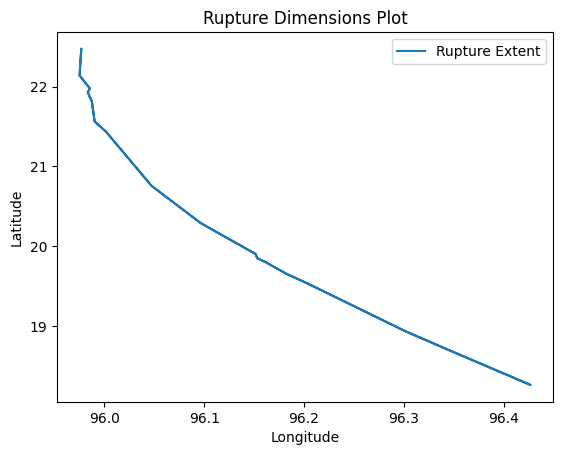

In [3]:
#Parse Rupture data 
rupture_parser = USGSParser(parser_type='rupture_json', mode='parse',rupture_json=file_path_rupturedata)
# Extract rupture coordinates from the parser.
rupture_x_coords, rupture_y_coords = rupture_parser.get_rupture_xy()

# Plotting function
fig, ax = plt.subplots()
ax.plot(rupture_x_coords, rupture_y_coords, '-', label='Rupture Extent')
ax.set_title('Rupture Dimensions Plot')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()
plt.show()

## Get Instruments Data 

In [4]:
# Parse Instruments Data 
instrument_parser = USGSParser(parser_type = 'instrumented_data',json_file=file_path_instrument_data)
instruments_data = instrument_parser.get_dataframe(value_type='pga')

print(instruments_data.columns)

# Show maximum values 
# Step 1: Find the index of the maximum value in the 'pga' column
max_pga_index = instruments_data['pga'].idxmax()

# Step 2: Retrieve and print the row with the maximum 'pga'
max_pga_row = instruments_data.loc[max_pga_index]
print("Row with the maximum PGA value:")
print(max_pga_row)

Index(['id', 'station_code', 'instrumentType', 'commType', 'station_name',
       'longitude', 'latitude', 'location', 'source', 'network',
       'station_type', 'vs30', 'elev', 'distance', 'rrup', 'repi', 'rhypo',
       'rjb', 'intensity', 'intensity_flag', 'intensity_stddev',
       'pga_selected', 'pgv_selected', 'predictions', 'mmi_from_pgm',
       'channel_number', 'HNE', 'HNN', 'HNZ', 'pga', 'pga_unit'],
      dtype='object')
Row with the maximum PGA value:
id                                                             GE.NPW
station_code                                                      NPW
instrumentType                                                    UNK
commType                                                          UNK
station_name                    DMH/GEOFON Station Naypyitaw, Myanmar
longitude                                                      96.138
latitude                                                       19.779
location                               

In [5]:
from modules.SHAKEtools import AccelerationUnitConverter

# convert units
converter = AccelerationUnitConverter()
instruments_data['HNE'] = converter.convert_unit(instruments_data['HNE'],'%g','cm/s2')
instruments_data['HNN'] = converter.convert_unit(instruments_data['HNN'],'%g','cm/s2')
instruments_data['HNZ'] = converter.convert_unit(instruments_data['HNZ'],'%g','cm/s2')
instruments_data['pga'] = converter.convert_unit(instruments_data['pga'],'%g','cm/s2')
instruments_data['pga_selected'] = converter.convert_unit(instruments_data['pga'].replace('null', np.nan),'%g','cm/s2')


instruments_data['pga_unit'] = 'cm/s2'

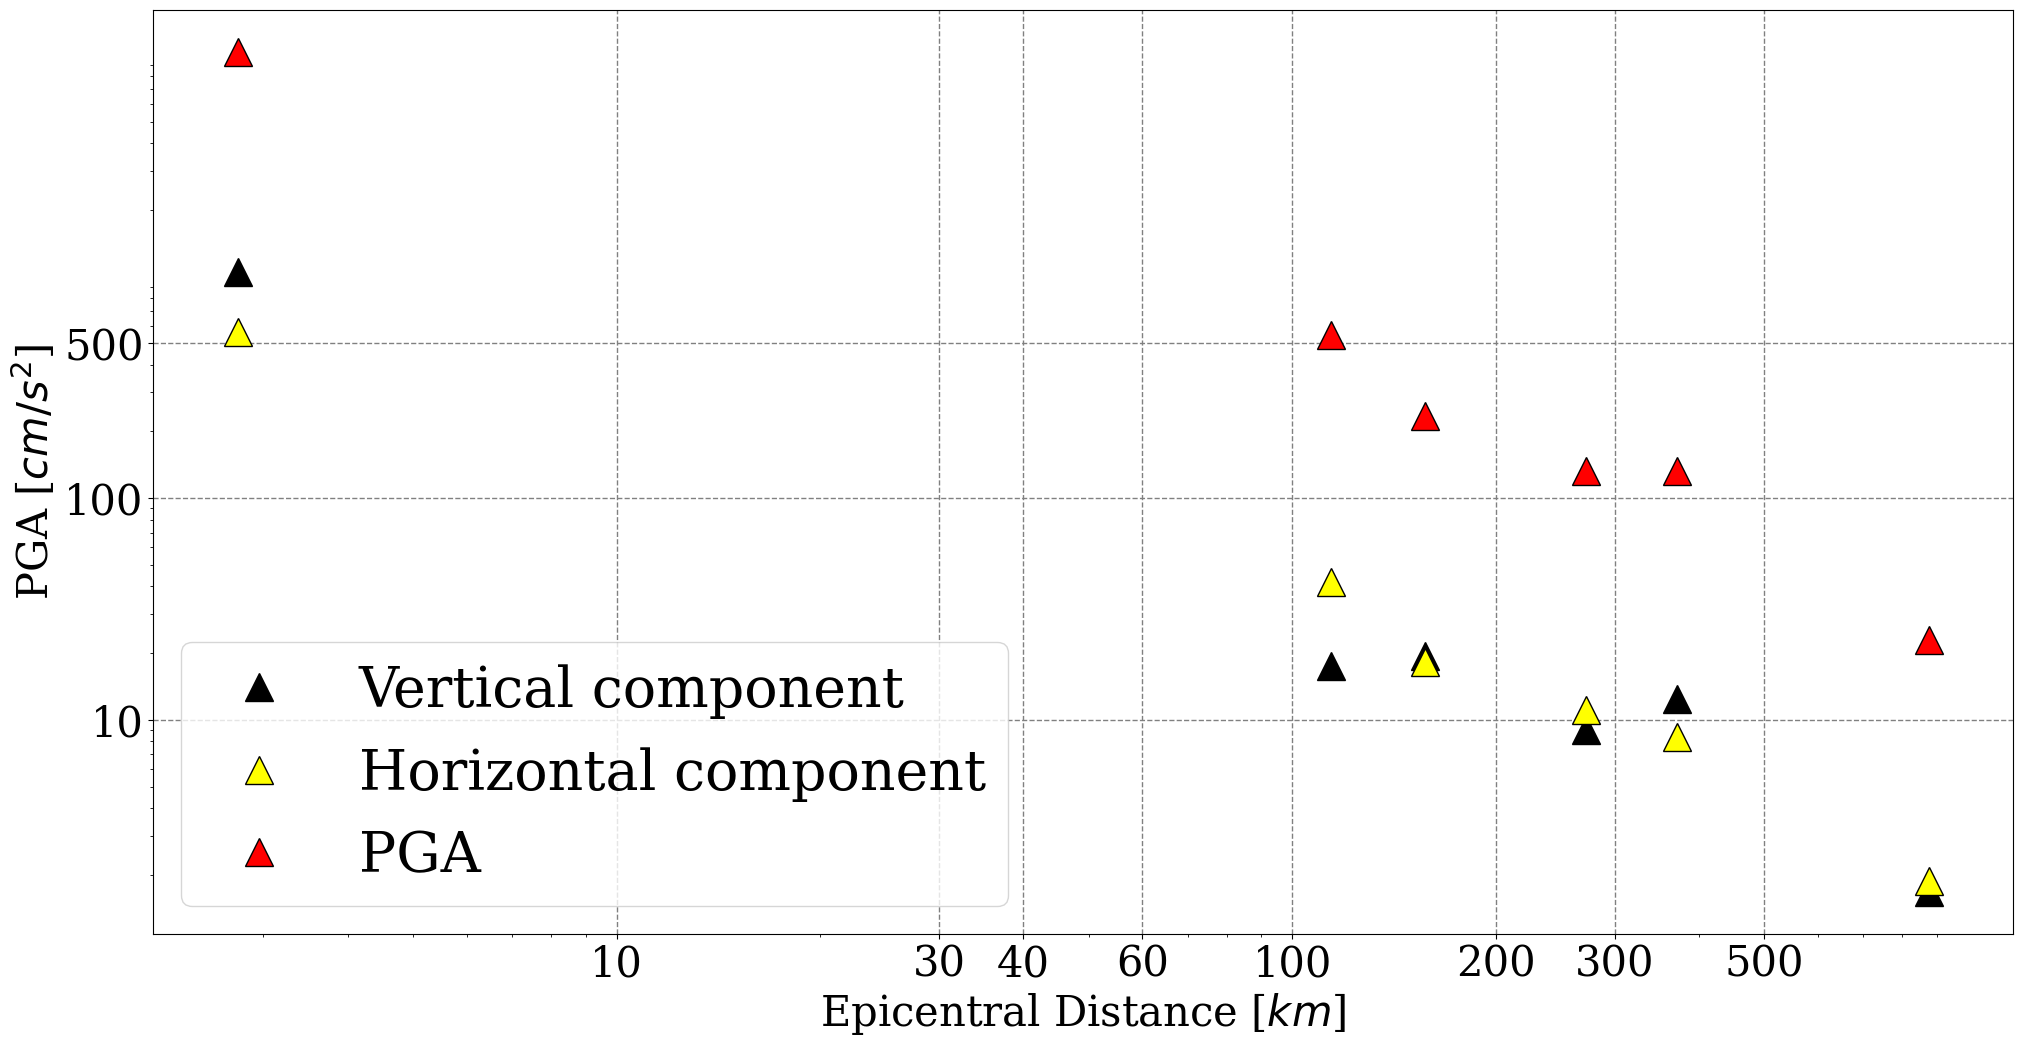

In [6]:
import matplotlib.ticker as ticker


plt.style.use('./bins/instruments_data.mplstyle')



plt.plot(instruments_data['distance'],
                              instruments_data['HNZ'],
                              'k^',mfc='k',markersize=20, label = 'Vertical component')


# Compute the max of HNE and HNN for each row
max_H = instruments_data[['HNE', 'HNN']].min(axis=1)  # :contentReference[oaicite:0]{index=0}
plt.plot(instruments_data['distance'],
                              max_H,
                              'k^',mfc='yellow',markersize=20, label = 'Horizontal component')

plt.plot(instruments_data['distance'],
                              instruments_data['pga_selected'].replace('null', np.nan),
                              'k^',mfc='r',markersize=20, label = 'PGA')


plt.grid()
plt.legend()

# set axis scale 
plt.xscale('log', base=10)
plt.yscale('log',base=10)

# Customize tick labels to scalar format
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

# Ensure that every tick label is formatted in scalar (no scientific notation)
ax.xaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_scientific(False)


#set label sizes 
plt.xlabel('Epicentral Distance [$km$]', fontsize=30)
plt.ylabel('PGA [$cm/s^2$]', fontsize=30)

#axis bounds 
ticksx = [10,30, 40, 60, 100, 200, 300,500]
ticksy = [10,100,500]

plt.xticks(ticksx)
plt.yticks(ticksy)


plt.savefig(f"{output_path}/{event_id}_SeismicStationrecords_{version}.png", bbox_inches='tight')
plt.savefig(f"{output_path}/{event_id}_SeismicStationrecords_{version}.pdf", bbox_inches='tight')




In [ ]:
# Example usage:
if __name__ == "__main__":
    mapper = SHAKEmapper()
    mapper.set_extent(map_extent)
    
    fig, ax = mapper.create_basemap()  #([90.4, 103.4, 13.0, 26.8])
    
    #mapper.add_vs30_layer()
    plt.style.use('./bins/latex_shakemap_style.mplstyle')


    mapper.add_vs30_layer()
    mapper.add_stations(instruments_data['longitude'],instruments_data['latitude'])
        

    mapper.add_cities(population=1000000)
    
    mapper.update_legend(alpha=0.9)

    plt.savefig(f"{output_path}/{event_id}_SeismicStations_map_{version}.png", bbox_inches='tight')
    plt.savefig(f"{output_path}/{event_id}_SeismicStations_map_{version}.pdf", bbox_inches='tight')



    
    plt.show()

## Get DYFI? Data 

### DYFI? data from stationlist.json

In [ ]:
# Parse Instruments Data 
dyfi_parser = USGSParser(parser_type = 'instrumented_data',json_file=file_path_instrument_data)
dyfi_data_stationslist = dyfi_parser.get_dataframe(value_type='mmi')

print(dyfi_data_stationslist.columns)

In [ ]:
dyfi_data_stationslist

In [ ]:
import matplotlib.ticker as ticker



plt.style.use('./bins/intensity_data.mplstyle')

from modules.SHAKEtools import contour_scale

cmap,bounds, ticks, norm, used_scale = contour_scale('mmi')


# this will turn non‐parseable values (like "null") into actual NaN
dyfi_data_stationslist['intensity'] = pd.to_numeric(
    dyfi_data_stationslist['intensity'], errors='coerce'
)  # :contentReference[oaicite:0]{index=0}

# also ensure 'distance' is numeric
dyfi_data_stationslist['distance'] = pd.to_numeric(
    dyfi_data_stationslist['distance'], errors='coerce'
)

# drop any rows that became NaN in either column
dyfi_data_stationslist.dropna(
    subset=['intensity', 'distance'], inplace=True
)




# Create scatter plot
fig, ax = plt.subplots()
sc = ax.scatter(
    dyfi_data_stationslist['distance'], dyfi_data_stationslist['intensity'],
    c=np.asarray(dyfi_data_stationslist['intensity']), cmap=cmap, norm=norm,
    marker='o',
    s=500,edgecolors='black',
    linewidths=2, label = 'DYFI?'
)



#plt.plot(dyfi_data['dist'],dyfi_data['intensity'],
#                              '.',mfc='gray',markersize=20, label = 'Intenisty Component')


#set label sizes 
plt.xlabel('Epicentral Distance [$km$]', fontsize=30)
plt.ylabel('MMI', fontsize=30)


# Add colorbar for intensity
cb = plt.colorbar(sc, ax=ax)
cb.set_label('MMI')


ax.legend(loc='upper right')

plt.tight_layout()


# Now save the figures
plt.savefig(f"{output_path}/{event_id}_dyfi_stationslist_{version}.png", bbox_inches='tight')
plt.savefig(f"{output_path}/{event_id}_dyfi_stationslist_{version}.pdf", bbox_inches='tight')



plt.show()

In [ ]:
# Example usage:
if __name__ == "__main__":
    mapper = SHAKEmapper()
    mapper.set_extent(map_extent)
    
    fig, ax = mapper.create_basemap()  #([90.4, 103.4, 13.0, 26.8])
    
    #mapper.add_vs30_layer()
    plt.style.use('./bins/latex_shakemap_style.mplstyle')


    mapper.add_vs30_layer()
    mapper.add_dyfi(dyfi_data_stationslist['longitude'],dyfi_data_stationslist['latitude'],dyfi_data_stationslist['intensity'])
        

    mapper.add_cities(population=1000000)
    
    mapper.update_legend(alpha=0.9)

    plt.savefig(f"{output_path}/{event_id}_dyfi_data_stationslist_map_{version}.png", bbox_inches='tight')
    plt.savefig(f"{output_path}/{event_id}_dyfi_data_stationslist_map_{version}.pdf", bbox_inches='tight')


    
    plt.show()

### DYFI? from CDI 

In [ ]:
# Parse did you feel it data 

dyfi_parser = USGSParser(parser_type='dyfi_data', file_path=file_path_dyfixml)
dyfi_data = dyfi_parser.get_dataframe()
dyfi_data

In [ ]:

plt.style.use('./bins/intensity_data.mplstyle')

from modules.SHAKEtools import contour_scale
from matplotlib.patches import Patch

cmap,bounds, ticks, norm, used_scale = contour_scale('mmi')

# Define edge colors based on nresp
edge_colors = np.where(
    dyfi_data['No. of responses'] >= 3, 'red',  # Included
    'black'                          # Excluded
)


# Create scatter plot
fig, ax = plt.subplots()
sc = ax.scatter(
    dyfi_data['Hypocentral distance'], dyfi_data['CDI'],
    c=dyfi_data['CDI'], cmap=cmap, norm=norm,
    marker='o',
    s=500,
    edgecolors=edge_colors,
    linewidths=2
)



#plt.plot(dyfi_data['dist'],dyfi_data['intensity'],
#                              '.',mfc='gray',markersize=20, label = 'Intenisty Component')


#set label sizes 
plt.xlabel('Epicentral Distance [$km$]', fontsize=30)
plt.ylabel('MMI', fontsize=30)


# Add colorbar for intensity
cb = plt.colorbar(sc, ax=ax)
cb.set_label('MMI')

# Create custom legend for edge colors
legend_handles = [
    Patch(facecolor='white', edgecolor='red', linewidth=1.5, label='Included (nresp ≥ 3)'),
    Patch(facecolor='white', edgecolor='black', linewidth=1.5, label='Excluded (nresp < 3)')
]
ax.legend(handles=legend_handles, loc='upper right')

plt.tight_layout()


from pathlib import Path


plt.xlim(0, 1000)  

# Now save the figures
# Now save the figures
plt.savefig(f"{output_path}/{event_id}_dyfi_cdi_{version}.png", bbox_inches='tight')
plt.savefig(f"{output_path}/{event_id}_dyfi_cdi_{version}.pdf", bbox_inches='tight')



plt.show()



In [ ]:
# Example usage:
if __name__ == "__main__":
    mapper = SHAKEmapper()
    mapper.set_extent(map_extent)
    
    fig, ax = mapper.create_basemap()  #([90.4, 103.4, 13.0, 26.8])
    
    #mapper.add_vs30_layer()
    plt.style.use('./bins/latex_shakemap_style.mplstyle')


    mapper.add_vs30_layer()
    mapper.add_dyfi(dyfi_data['Longitude'],dyfi_data['Latitude'],dyfi_data['CDI'])
        

    mapper.add_cities(population=1000000)
    
    mapper.update_legend(alpha=0.9)

    plt.savefig(f"{output_path}/{event_id}_dyfi_data_cdi_map_{version}.png", bbox_inches='tight')
    plt.savefig(f"{output_path}/{event_id}_dyfi_data_cdi_map_{version}.pdf", bbox_inches='tight')


    
    plt.show()

## Get Shakemap

### MMI Shakeamp 

In [ ]:
shakemap_parser = USGSParser(parser_type="shakemap_xml", imt='mmi', xml_file=xml_shakemap_file_path)
shakemap_metadata = shakemap_parser.get_metadata()

shakemap_metadata

In [ ]:
# Example usage:
if __name__ == "__main__":
    #mapper.add_vs30_layer()
    plt.style.use('./bins/latex_shakemap_style.mplstyle')

    mapper = SHAKEmapper()
    
    fig, ax = mapper.create_basemap()  #([90.4, 103.4, 13.0, 26.8])
    
    mapper.add_usgs_shakemap(shakemap_parser)

    #mapper.add_dyfi(dyfi_data['Longitude'],dyfi_data['Latitude'],dyfi_data['CDI'])
    mapper.add_dyfi(dyfi_data_stationslist['longitude'],dyfi_data_stationslist['latitude'],dyfi_data_stationslist['intensity'])

    mapper.add_stations(instruments_data['longitude'],instruments_data['latitude'])

    #x_coords, y_coords = parser.get_rupture_xy()
    mapper.add_rupture(rupture_x_coords,rupture_y_coords )

    mapper.add_cities(population=1000000)

    mapper.add_epicenter(shakemap_metadata['event']['lon'],shakemap_metadata['event']['lat'])
    
    mapper.update_legend(alpha=0.9)

    plt.savefig(f"{output_path}/{event_id}_mmishakemap_{version}.png", bbox_inches='tight')
    plt.savefig(f"{output_path}/{event_id}_mmishakemap_{version}.pdf", bbox_inches='tight')


    
    plt.show()

In [ ]:
# Example usage:
if __name__ == "__main__":
    #mapper.add_vs30_layer()
    plt.style.use('./bins/latex_shakemap_style.mplstyle')

    mapper = SHAKEmapper()
    
    fig, ax = mapper.create_basemap()  #([90.4, 103.4, 13.0, 26.8])
    
    mapper.add_usgs_shakemap(shakemap_parser)

    #mapper.add_dyfi(dyfi_data['Longitude'],dyfi_data['Latitude'],dyfi_data['CDI'])
    mapper.add_dyfi(dyfi_data['Longitude'],dyfi_data['Latitude'],dyfi_data['CDI'])

    mapper.add_stations(instruments_data['longitude'],instruments_data['latitude'])

    #x_coords, y_coords = parser.get_rupture_xy()
    mapper.add_rupture(rupture_x_coords,rupture_y_coords )

    mapper.add_cities(population=1000000)

    mapper.add_epicenter(shakemap_metadata['event']['lon'],shakemap_metadata['event']['lat'])
    
    mapper.update_legend(alpha=0.9)

    plt.savefig(f"{output_path}/{event_id}_mmishakemapCDI_{version}.png", bbox_inches='tight')
    plt.savefig(f"{output_path}/{event_id}_mmishakemapCDI_{version}.pdf", bbox_inches='tight')


    
    plt.show()

### PGA Shakemap 

In [ ]:
shakemap_parser = USGSParser(parser_type="shakemap_xml", imt='pga', xml_file=xml_shakemap_file_path)
shakemap_metadata = shakemap_parser.get_metadata()

In [ ]:
# Example usage:
if __name__ == "__main__":
    #mapper.add_vs30_layer()
    plt.style.use('./bins/latex_shakemap_style.mplstyle')

    mapper = SHAKEmapper()
    
    fig, ax = mapper.create_basemap()  #([90.4, 103.4, 13.0, 26.8])
    
    mapper.add_usgs_shakemap(shakemap_parser)

    #mapper.add_dyfi(dyfi_data['Longitude'],dyfi_data['Latitude'],dyfi_data['CDI'])
    mapper.add_dyfi(dyfi_data_stationslist['longitude'],dyfi_data_stationslist['latitude'],dyfi_data_stationslist['intensity'])

    mapper.add_stations(instruments_data['longitude'],instruments_data['latitude'])

    #x_coords, y_coords = parser.get_rupture_xy()
    mapper.add_rupture(rupture_x_coords,rupture_y_coords )

    mapper.add_cities(population=1000000)

    mapper.add_epicenter(shakemap_metadata['event']['lon'],shakemap_metadata['event']['lat'])
    
    mapper.update_legend(alpha=0.9)

    plt.savefig(f"{output_path}/{event_id}_pgashakemap_{version}.png", bbox_inches='tight')
    plt.savefig(f"{output_path}/{event_id}_pgaishakemap_{version}.pdf", bbox_inches='tight')


    
    plt.show()

In [ ]:
import sys 
sys.exit()

# Shakemap Temporal Evolution


## Set Up Enviroments And Shakemap Data files

In [ ]:
from modules.SHAKEtime import *
#from pathlib import Path

In [ ]:
event_id = 'us7000pn9s'
event_time = '2025-03-28 06:20:52'

shakemap_folder = "./export/SHAKEfetch/usgs-shakemap-versions"
pager_folder = "./export/SHAKEfetch/usgs-pager-versions"
rupture_folder = "./export/SHAKEfetch/usgs-rupture-versions"
stations_folder = "./export/SHAKEfetch/usgs-instruments_data-versions"

version_list = ['001', '002','003', '004','006', '007', '008','009', '011', '012']
version_list = ['001', '002','003', '004','005','006', '007', '008','009', '011', '012','013','014','015','016','017','018','019','020']

selected_cities = ['Mandalay', 'Nay Pyi Taw','Chiang Mai' ,'Taungoo','Bangkok']

#version_list = [ '001','020']

## Get SHAKEtime Summary 

### Computing SHAKEsummary 

In [ ]:
shake = SHAKEtime(event_id, event_time, shakemap_folder, pager_folder, file_type=2)
shake.get_shake_summary(version_list)

In [ ]:
#add further information
shake.add_shakemap_pgm()
shake.add_shakemap_stdpgm()
shake.add_rate_to_summary(version_list=version_list, metric="mmi", use_cache=False)
shake.add_rate_to_summary(version_list=version_list, metric="pga", use_cache=False)
shake.add_rate_to_summary(version_list=version_list, metric="pgv", use_cache=False)
shake.add_rate_to_summary(version_list=version_list, metric="psa10", use_cache=False)

shake.add_pager_exposure()
shake.add_cities_impact(selected_cities)
shake.add_alerts(version_list, alert_type="fatality")
shake.add_alerts(version_list, alert_type="economic")




In [ ]:
# Define the output directory
output_dir = Path(f"./export/SHAKEtime/{event_id}")

# Create it (and any missing parents) if it doesn’t already exist
output_dir.mkdir(parents=True, exist_ok=True)  # pathlib.Path.mkdir(parents=True, exist_ok=True) :contentReference[oaicite:0]{index=0}

# Build the full path to your CSV file



shake.export_summary(output_dir, file_type='csv')

### Importing SHAKEsummary 

In [ ]:
shake = SHAKEtime(event_id, event_time, shakemap_folder, pager_folder, file_type=2)


csv_pathh = f"./export/SHAKEtime/{event_id}/SHAKEtime-Summary-{event_id}.csv"

shake.import_summary(csv_pathh)


dataframe = shake.get_dataframe()


dataframe

## Get Unified Grid

### Compute Unified Grid

In [ ]:
#shake.clear_grid_cache()
#shake.clear_summary_cache()

# Create it (and any missing parents) if it doesn’t already exist
output_dir = Path(f"./export/SHAKEtime/{event_id}")
output_dir.mkdir(parents=True, exist_ok=True)  # pathlib.Path.mkdir(parents=True, exist_ok=True) :contentReference[oaicite:0]{index=0}


metric = 'pga'
shake.get_rate_grid(version_list, metric=metric, use_cache = False)
shake.export_unified_grid(output_dir, file_type='pickle')

metric = 'pgv'
shake.get_rate_grid(version_list, metric=metric, use_cache = False)
shake.export_unified_grid(output_dir, file_type='pickle')

metric = 'psa10'
shake.get_rate_grid(version_list, metric=metric, use_cache = False)
shake.export_unified_grid(output_dir, file_type='pickle')

metric = 'mmi'
shake.get_rate_grid(version_list, metric=metric, use_cache = False)
shake.export_unified_grid(output_dir, file_type='pickle')

### Import unidified grid

In [ ]:
shake = SHAKEtime(event_id, event_time, shakemap_folder, pager_folder, file_type=2)

csv_pathh = f"./export/SHAKEtime/{event_id}/SHAKEtime_unified_grid_{event_id}_mmi.csv"

shake.import_unified_grid(csv_pathh)

#shake.get_unified_grid (use_cache = True)

## Export Plots 

### Plot Rate Maps 

In [ ]:
from modules.SHAKEtime import SHAKEtime

shake = SHAKEtime(event_id, event_time, shakemap_folder, pager_folder, file_type=2)

plt.style.use('./bins/latex_rateofchangemap_style.mplstyle')


# Plot rate maps.

rate_maps = shake.plot_rate_maps(version_list, metric='pga',output_path="./export",plot_colorbar=False, show_title=False, dpi = 100)

rate_maps = shake.plot_rate_maps(version_list, metric='pgv',output_path="./export",plot_colorbar=False, show_title=False, dpi = 100)

rate_maps = shake.plot_rate_maps(version_list, metric='psa10',output_path="./export",plot_colorbar=False, show_title=False, dpi = 100)

rate_maps = shake.plot_rate_maps(version_list, metric='mmi',output_path="./export",plot_colorbar=False, show_title=False, dpi = 100)


In [ ]:
from modules.SHAKEtime import SHAKEtime

shake = SHAKEtime(event_id, event_time, shakemap_folder, pager_folder, file_type=2)

plt.style.use('./bins/latex_rateofchangemap_style.mplstyle')

# Plot rate maps.
rate_maps = shake.plot_ratemap_details(version_list, metric='mmi',rupture_folder=rupture_folder,stations_folder=stations_folder, output_path="./export",plot_colorbar=False, show_title=False, dpi = 100)

In [ ]:
shake.get_dataframe()

### Plot Population Exposure 

In [ ]:
plt.style.use('./bins/latex_fig_style.mplstyle')

# Plot population exposure.
fig_pop, ax_pop = shake.plot_pop_exposure(version_list=version_list, output_path="./export",x_ticks='TaE_h')
plt.show()


### Plot Alerts 

In [ ]:
plt.style.use('./bins/latex_fig_style.mplstyle')

# plot Fatalities 
shake.plot_alerts(version_list, alert_type="fatality", output_path="./export",x_ticks='TaE_h')

#plot Economic 
shake.plot_alerts(version_list, alert_type="economic", output_path="./export",x_ticks='TaE_h')



### Plot All SHAKEmaps

In [ ]:
plt.style.use('./bins/latex_shakemap_style.mplstyle')
# Plot ShakeMaps.

shake.plot_shakemaps(version_list, metric="mmi", rupture_folder=rupture_folder,stations_folder=stations_folder, output_path="./export" ,plot_colorbar=False, show_title=False, dpi=100)

shake.plot_shakemaps(version_list, metric="pga", rupture_folder=rupture_folder,stations_folder=stations_folder, output_path="./export" ,plot_colorbar=False, show_title=False, dpi=100)

shake.plot_shakemaps(version_list, metric="pgv", rupture_folder=rupture_folder,stations_folder=stations_folder, output_path="./export" ,plot_colorbar=False, show_title=False, dpi=100)

    

In [ ]:
plt.style.use('./bins/latex_shakemap_style.mplstyle')

shake.plot_std_maps(version_list, metric="mmi", rupture_folder=rupture_folder, output_path="./export", plot_colorbar=False, show_title=False, dpi=100)

shake.plot_std_maps(version_list, metric="pga", rupture_folder=rupture_folder, output_path="./export", plot_colorbar=False, show_title=False, dpi=100)

shake.plot_std_maps(version_list, metric="pgv", rupture_folder=rupture_folder, output_path="./export", plot_colorbar=False, show_title=False, dpi=100)

# Shakemap Evolution Analysis

## Hazrad Temporal Displacement

### Single Metric 

In [ ]:
plt.style.use('./bins/latex_fig_style.mplstyle')

metric_type = 'mmi'


shake.plot_thd(metric_type=metric_type, x_ticks= 'TaE_h', output_path="./export")

### Multiple Metric

In [ ]:
plt.style.use('./bins/latex_fig_style.mplstyle')


from pathlib import Path

metrics = [
    'mmi', 'mmi_delta', 'mmi_rate',
    'pga', 'pga_delta', 'pga_rate',
    'pgv', 'pgv_delta', 'pgv_rate',
    'psa10', 'psa10_delta', 'psa10_rate',
    'stdmmi', 'stdpga', 'stdpgv', 'stdpsa10'
]

for metric in metrics:
    try:
        shake.plot_thd(metric_type=metric, x_ticks= 'TaE_h', output_path="./export") 
        print(f"✅ Completed HTD for metric '{metric}'")
    except Exception as e:
        print(f"❌ Failed HTD for metric '{metric}': {e}")


## Quantify Shakemap Evolution 

In [ ]:
from modules.SHAKEtime import *
from pathlib import Path


event_id = 'us7000pn9s'
event_time = '2025-03-28 06:20:52'

shakemap_folder = "./export/SHAKEfetch/usgs-shakemap-versions"
pager_folder = "./export/SHAKEfetch/usgs-pager-versions"
rupture_folder = "./export/SHAKEfetch/usgs-rupture-versions"

version_list = ['001', '002','003', '004','006', '007', '008','009', '011', '012']
version_list = ['001', '002','003', '004','005','006', '007', '008','009', '011', '012','013','014','015','016','017','018','019','020']

selected_cities = ['Mandalay', 'Nay Pyi Taw','Chiang Mai' ,'Taungoo','Bangkok']



shake = SHAKEtime(event_id, event_time, shakemap_folder, pager_folder, file_type=2)

csv_pathh = f"./export/SHAKEtime/{event_id}/SHAKEtime-Summary-{event_id}.csv"

shake.import_summary(csv_pathh)

dataframe = shake.get_dataframe()


#shake = SHAKEtime(event_id, event_time, shakemap_folder, pager_folder, file_type=2)

csv_pathh = f"./export/SHAKEtime/{event_id}/SHAKEtime_unified_grid_{event_id}_mmi.csv"
shake.import_unified_grid(csv_pathh)



#shake.get_unified_grid (use_cache = True)

In [ ]:
res = shake.analyze_auxiliary_influences(
    version_list,
    rupture_folder="./export/SHAKEfetch/usgs-rupture-versions",
    station_folder="./export/SHAKEfetch/usgs-instruments_data-versions",
    dyfi_folder="./export/SHAKEfetch/usgs-instruments_data-versions",
    thresholds=[6.0, 7.0, 8.0],
    uncertainty_percentile=90.0,
    bootstrap_iters=200,
    radius_km=30,
    metric='mmi'
)

# your merged table of auxiliaries + diagnostics:
print(res['merged'])

# correlation heatmap:
print(res['correlation'])

# inspect OLS for how station_count explains ΔMMI:
print(res['regressions']['mae'].summary())

In [ ]:
plt.style.use('./bins/latex_fig_style.mplstyle')


shake.plot_auxiliary_results(res,output_path='./export')

In [ ]:
shake.export_auxiliary_results(res,output_dir='./export')

In [ ]:
# 1) Area where MMI > 5.0
df_area = shake.compute_threshold_exceedance_area(7, version_list)
print(df_area)


In [ ]:
# 2) Global diff stats between v001 and v002
stats = shake.compute_global_diff_stats(version_list=version_list)
print(stats)


In [ ]:
# 3) Spatial Pearson correlations between versions
corr_series = shake.spatial_correlation(versions, metric="mmi", method="pearson")
print(corr_series)


In [ ]:
# 4) Variogram on v003
vg_params = shake.variogram_analysis("003", metric="mmi", plot=True)
print(vg_params)

In [ ]:
# 5) Area where std-dev > 90th percentile
df_unc = shake.area_of_uncertainty_change(versions, metric="mmi", percentile=90)
print(df_unc)

In [ ]:
# 7) Bootstrap uncertainty CIs for means/stds
boot_ci = shake.bootstrap_uncertainty(versions, metric="mmi", n_iter=500)
print(boot_ci)

In [ ]:

evo_df = shake.quantify_evolution(
    version_list=versions,
    metric="mmi",
    thresholds=[3.0, 4.0],
    uncertainty_percentile=90.0,
    bootstrap_iters=500
)

In [ ]:
# 8) Plot evolution of all diagnostics across versions
evo_df = shake.plot_evolution(
    versions,
    metric="mmi",
    thresholds=[4.0, 5.0],
    uncertainty_percentile=90.0,
    bootstrap_iters=200,
    save_path="./export")

## Analyze Shakemap Auxiliary Influences

In [ ]:
# only rupture influence
res_rup = shake.analyze_auxiliary_influences(
    versions,
    rupture_folder="./export/SHAKEfetch/usgs-rupture-versions"
)
print(res_rup['aux'])
print(res_rup['correlation'])









In [ ]:
# station + DYFI
res_sta_dyfi = shake.analyze_auxiliary_influences(
    versions,
    rupture_folder="./export/SHAKEfetch/usgs-rupture-versions",
    station_folder="./export/SHAKEfetch/usgs-instruments_data-versions",
    dyfi_folder="./export/SHAKEfetch/usgs-instruments_data-versions",

    radius_km=30
)
print(res_sta_dyfi)


In [ ]:

res = shake.analyze_auxiliary_influences(
    versions,
    rupture_folder="./export/SHAKEfetch/usgs-rupture-versions",
    station_folder="./export/SHAKEfetch/usgs-instruments_data-versions",
    dyfi_folder="./export/SHAKEfetch/usgs-instruments_data-versions",
    radius_km=30
)

# your merged table of auxiliaries + diagnostics:
print(res['merged'])

# correlation heatmap:
print(res['correlation'])

# inspect OLS for how station_count explains ΔMMI:
print(res['regressions']['mae'].summary())


In [ ]:
# your merged table of auxiliaries + diagnostics:
print(res_sta_dyfi['merged'])

# correlation heatmap:
print(res_sta_dyfi['correlation'])

# inspect OLS for how station_count explains ΔMMI:
print(res_sta_dyfi['regressions']['mae'].summary())

# SHAKEconsequence

In [ ]:
from modules.SHAKEtime import *


In [ ]:
registry = [
    {"event_id": "us7000pn9s",  "event_type": "main_event",  "file_path": "./export-shakefetch/SHAKEfetch/usgs-shakemap-versions/us7000pn9s/us7000pn9s_us_1_grid.xml"},
    {"event_id": "us6000q5ps", "event_type": "aftershock",  "file_path": "./export-shakefetch/SHAKEfetch/usgs-shakemap-versions/us6000q5ps/us6000q5ps_us_1_grid.xml"},
    {"event_id": "us7000pn9z", "event_type": "aftershock",  "file_path": "./export-shakefetch/SHAKEfetch/usgs-shakemap-versions/us7000pn9z/us7000pn9z_us_1_grid.xml"},
]

registry = [
    {
        "event_id": "us7000pn9s",
        "event_type": "main_event",
        "file_path": "./export-shakefetch/SHAKEfetch/usgs-shakemap-versions/us7000pn9s/us7000pn9s_us_1_grid.xml",
        "std_file_path": "./export-shakefetch/SHAKEfetch/usgs-shakemap-versions/us7000pn9s/us7000pn9s_us_1_uncertainty.xml"
    },
    {
        "event_id": "us6000q5ps",
        "event_type": "aftershock",
        "file_path": "./export-shakefetch/SHAKEfetch/usgs-shakemap-versions/us6000q5ps/us6000q5ps_us_1_grid.xml",
        "std_file_path": "./export-shakefetch/SHAKEfetch/usgs-shakemap-versions/us6000q5ps/us6000q5ps_us_1_uncertainty.xml"
    },
    {
        "event_id": "us7000pn9z",
        "event_type": "aftershock",
        "file_path": "./export-shakefetch/SHAKEfetch/usgs-shakemap-versions/us7000pn9z/us7000pn9z_us_1_grid.xml",
        "std_file_path": "./export-shakefetch/SHAKEfetch/usgs-shakemap-versions/us7000pn9z/us7000pn9z_us_1_uncertainty.xml"
    }
]



In [ ]:
#Turkey Earthqauke 
event_ids = [
    "us6000jllz","us6000jlqa","us6000jlm1","us6000jlm9","us6000jlmh","us6000jlqe",
    "us6000jlql","us6000jlrc","us6000jm1y","us6000jm5e","us6000jmgf","us6000jqcn"]

#Turkey Earthqauke 
event_ids = [
    "us6000jllz","us6000jlqa","us6000jlm1","us6000jqcn","us6000jlrc","us6000jm1y","us6000jlqe","us6000jlql","us6000jlnn","us6000jlm9","us6000jqjc",
    "us6000jm5e","us6000jmgf","us6000jm6p","us6000jlsu","us6000jnt0","us6000jmat","us6000jm7f","us6000jm2r","us6000jls3","us6000jlmn","us6000jlmh",
    "us6000jrw4","us6000jriw","us6000jpff","us6000jm1p","us6000jmh3","us6000jlqr","us6000jlmf","us7000jgyv","us6000jpyq","us6000jngk","us6000jmg1",
    "us6000jm96","us6000jlta","us6000jls6","us6000jlrv","us6000jlnf","us6000jmn0"]




registry = []  # start with an empty list
for idx, event in enumerate(event_ids):  # get both index and event ID :contentReference[oaicite:0]{index=0}
    # use a conditional expression to pick the event type
    event_type = "main_event" if idx == 0 else "aftershock"
    
    # build the entry dict and append it
    registry.append({
        "event_id":     event,
        "event_type":   event_type,
        "file_path":    f"./export-shakefetch-turkey/SHAKEfetch/usgs-shakemap-versions/{event}/{event}_us_1_grid.xml",
        "std_file_path":f"./export-shakefetch-turkey/SHAKEfetch/usgs-shakemap-versions/{event}/{event}_us_1_uncertainty.xml"
    })


In [ ]:
registry

In [ ]:
sc = SHAKEcumulative()

#meta_df = sc.build_metadata_table(registry)


#meta_df

In [ ]:
sc.ingest_event_shakemaps( soil_consideration=False,
        soil_method=None,
        gmice_model='WordenEtAl12'registry, metric='mmi')
        soil_consideration=False,


In [ ]:
sc.combine_event_shakemaps(registry, metric='mmi', write_std_to_df=True,interp_method='nearest', use_cache=False)


In [ ]:
sc.get_combined_data()

In [ ]:
sc.get_bayesian_shakemap(column_prefix="mmi", mode="model_default")

sc.get_bayesian_shakemap(column_prefix="mmi", mode="main_only")

In [ ]:
sc.get_combined_data()

In [ ]:
I am trying to write a description of analysis that I have performed to evaluate the temporal evolution of shakemap, I will provide you with the outline I have started and I have already written somethings, I would like you to enrich my text and descriotions with further details when necessary, I have used a python code to do this analysis I can also provide you with the code if needed but I think my starting description should give you a good start 

In [ ]:
sc.get_mean_shakemap()
sc.get_max_shakemap()

In [ ]:
sc.get_rms_shakemap()

In [ ]:
weights = {
    "us7000pn9s": 0.5,  # main event gets full weight
    "us6000q5ps": 0.2,  # aftershock 1 is slightly less important
    "us7000pn9z": 0.3   # aftershock 2 is even less important
}


# By magnitude only
sc.get_weighted_mean_shakemap(use_magnitude=True)

# By time-decay only
sc.get_weighted_mean_shakemap(use_time_decay=True)

# Custom weights + magnitude
sc.get_weighted_mean_shakemap(weights)


sc.get_weighted_mean_shakemap(use_distance=True)


In [ ]:
sc.get_quantile_shakemap()

In [ ]:
sc.get_probability_of_exceedance(5)

In [ ]:
sc.get_exceedance_count(7)

In [ ]:
data = sc.get_combined_data()

data


In [ ]:
sc.available_plots()

In [ ]:
column = 'cumulative_mbayesian'


mapper = SHAKEmapper()
fig,ax = mapper.create_basemap()

mapper.add_shakemap(data['lon'],data['lat'],data[column],imt_type='mmi')

#print(mapper.get_extent())

#mapper.update_extent([max(data['lon']), min(103.4, 13.0, 26.8])



In [ ]:
sc.get_data_extent('cumulative_mbayesian')

In [ ]:
extent = sc.get_data_extent('cumulative_mbayesian')


extend = [extent['lon_min'], extent['lon_max'],extent['lat_min'],extent['lat_max']]

extend

In [ ]:
column = 'cumulative_q75'


columns = [
 'cumulative_modelbayesian',
 'cumulative_mbayesian',
 'cumulative_mean',
 'cumulative_max',
 'cumulative_rms',
 'cumulative_mweighted_mean',
 'cumulative_tweighted_mean',
 'cumulative_weighted_mean',
 'cumulative_dweighted_mean',
 'cumulative_q75',
 'poe_5.0',
 'exceedance_count_7.0']


for column in columns:

    mapper = SHAKEmapper()
    fig,ax = mapper.create_basemap()
    
    #mapper.update_extent([35.9583, 37.325, 36.4167, 37.25)
    
    
    scatter = ax.scatter(
        data['lon'],data['lat'],
        c=data[column],
        cmap='viridis',
        transform=ccrs.PlateCarree(),
        zorder=8
    )
    
    # add a vertical colorbar to the right of the Axes
    cbar = fig.colorbar(
        scatter,             # the ScalarMappable from scatter()
        ax=ax,               # the Axes to attach the colorbar to
        orientation='vertical',
        label=f'{column}'    # optional label for the colorbar
    )

    mapper.update_extent([min(data['lon']), max(data['lon']), min(data['lat']), max(data['lat'])])
    
    fig.savefig(f'./export/viridis-{column}.png', dpi=300, bbox_inches='tight')



In [ ]:
column = 'cumulative_mbayesian'



columns = ['vs30',
 'mmi_us6000jllz',
 'std_mmi_us6000jllz',
 'mmi_us6000jlqa',
 'std_mmi_us6000jlqa',
 'mmi_us6000jlm1',
 'std_mmi_us6000jlm1',
 'mmi_us6000jqcn',
 'std_mmi_us6000jqcn',
 'mmi_us6000jlrc',
 'std_mmi_us6000jlrc',
 'mmi_us6000jm1y',
 'std_mmi_us6000jm1y',
 'mmi_us6000jlqe',
 'std_mmi_us6000jlqe',
 'mmi_us6000jlql',
 'std_mmi_us6000jlql',
 'mmi_us6000jlm9',
 'std_mmi_us6000jlm9',
 'mmi_us6000jm5e',
 'std_mmi_us6000jm5e',
 'mmi_us6000jmgf',
 'std_mmi_us6000jmgf',
 'mmi_us6000jlmh',
 'std_mmi_us6000jlmh',
 'cumulative_modelbayesian',
 'cumulative_mbayesian',
 'cumulative_mean',
 'cumulative_max',
 'cumulative_rms',
 'cumulative_mweighted_mean',
 'cumulative_tweighted_mean',
 'cumulative_weighted_mean',
 'cumulative_dweighted_mean',
 'cumulative_q75',
 'poe_5.0',
 'exceedance_count_7.0']


for column in columns: 
    mapper = SHAKEmapper()
    fig,ax = mapper.create_basemap()
    
    mapper.add_shakemap(data['lon'],data['lat'],data[column],imt_type='mmi')
    
    #print(mapper.get_extent())
    
    
    fig.savefig(f'./export/{column}.png', dpi=300, bbox_inches='tight')


In [ ]:
data.to_csv('test.csv')

In [ ]:
import sys 
sys. exit()

In [ ]:
# Example usage remains similar.
if __name__ == "__main__":

    from modules.SHAKEtime import *
    event_id = 'us7000pn9s'
    event_time = '2025-03-28 06:20:52'
    shakemap_folder = "./export/SHAKEfetch/usgs-shakemap-versions"
    pager_folder = "./export/SHAKEfetch/usgs-pager-versions"
    rupture_folder = "./export/SHAKEfetch/usgs-rupture-versions"
    version_list = ['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012','013','014','015','016','017','018','019','020']
    selected_cities = ['Mandalay', 'Nay Pyi Taw', 'Chiang Mai', 'Bangkok', 'Taungoo']

    version_list = [ '007','020']


    
    # Create instance with file_type default = 2
    shake = SHAKEtime(event_id, event_time, shakemap_folder, pager_folder, file_type=2)
    
    # Build summary and update metrics.
    shake.get_shake_summary(version_list)
    #shake.add_shakemap_pgm()
    #shake.add_shakemap_stdpgm()
    #shake.add_pager_exposure()
    #shake.add_cities_impact(selected_cities)
    #shake.add_rate_to_summary(version_list=version_list, metric="mmi")
    
    # Plot HTD.
    #fig_htd, ax_htd = shake.plot_HTD(metric_type="mmi")
    #out_htd = Path(f'./export/SHAKEtime-{shake.event_id}/Data-Assessment')
    #out_htd.mkdir(parents=True, exist_ok=True)
    #fig_htd.savefig(out_htd / f'{shake.event_id}_HTD.png', bbox_inches='tight', dpi=500)
    #fig_htd.savefig(out_htd / f'{shake.event_id}_HTD.pdf', bbox_inches='tight', dpi=500)
    #plt.show()
    
    # Plot rate maps.
    #rate_maps = shake.plot_rate_maps(version_list, output_path="./export", plot_colorbar="on")
    #for idx, (fig, ax, ver) in enumerate(rate_maps):
    #    fig.savefig(out_htd / f'{shake.event_id}_rate_map_{idx}.png', bbox_inches='tight', dpi=300)
    #    fig.savefig(out_htd / f'{shake.event_id}_rate_map_{idx}.pdf', bbox_inches='tight', dpi=300)
    #    plt.close(fig)
    
    # Plot Pager data.
    #pager_figures = shake.plot_pager_data(version_list, output_path="./export")
    #for fig, ax, prob_type, ver in pager_figures:
    #    plt.show()
    
    # Plot population exposure.
    #fig_pop, ax_pop = shake.plot_pop_exposure(version_list=version_list, output_path="./export")
    #plt.show()

    plt.style.use('./bins/latex_shakemap_style.mplstyle')
    
    # Plot ShakeMaps.
    shakemap_figures = shake.plot_shakemaps(version_list, rupture_folder, output_path="./export", plot_colorbar="off")
    for fig, ax, ver in shakemap_figures:
        plt.show()

# SHAKEtime

## testing 

In [ ]:
# Example usage remains similar.
if __name__ == "__main__":

    from modules.SHAKEtime import *
    event_id = 'us7000pn9s'
    event_time = '2025-03-28 06:20:52'
    shakemap_folder = "./export/SHAKEfetch/usgs-shakemap-versions"
    pager_folder = "./export/SHAKEfetch/usgs-pager-versions"
    rupture_folder = "./export/SHAKEfetch/usgs-rupture-versions"
    version_list = ['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012','013','014','015','016','017','018','019','020']
    selected_cities = ['Mandalay', 'Nay Pyi Taw', 'Chiang Mai', 'Bangkok', 'Taungoo']

    version_list = [ '007','020']


    
    # Create instance with file_type default = 2
    shake = SHAKEtime(event_id, event_time, shakemap_folder, pager_folder, file_type=2)
    
    # Build summary and update metrics.
    shake.get_shake_summary(version_list)
    #shake.add_shakemap_pgm()
    #shake.add_shakemap_stdpgm()
    #shake.add_pager_exposure()
    #shake.add_cities_impact(selected_cities)
    #shake.add_rate_to_summary(version_list=version_list, metric="mmi")
    
    # Plot HTD.
    #fig_htd, ax_htd = shake.plot_HTD(metric_type="mmi")
    #out_htd = Path(f'./export/SHAKEtime-{shake.event_id}/Data-Assessment')
    #out_htd.mkdir(parents=True, exist_ok=True)
    #fig_htd.savefig(out_htd / f'{shake.event_id}_HTD.png', bbox_inches='tight', dpi=500)
    #fig_htd.savefig(out_htd / f'{shake.event_id}_HTD.pdf', bbox_inches='tight', dpi=500)
    #plt.show()
    
    # Plot rate maps.
    #rate_maps = shake.plot_rate_maps(version_list, output_path="./export", plot_colorbar="on")
    #for idx, (fig, ax, ver) in enumerate(rate_maps):
    #    fig.savefig(out_htd / f'{shake.event_id}_rate_map_{idx}.png', bbox_inches='tight', dpi=300)
    #    fig.savefig(out_htd / f'{shake.event_id}_rate_map_{idx}.pdf', bbox_inches='tight', dpi=300)
    #    plt.close(fig)
    
    # Plot Pager data.
    #pager_figures = shake.plot_pager_data(version_list, output_path="./export")
    #for fig, ax, prob_type, ver in pager_figures:
    #    plt.show()
    
    # Plot population exposure.
    #fig_pop, ax_pop = shake.plot_pop_exposure(version_list=version_list, output_path="./export")
    #plt.show()

    plt.style.use('./bins/latex_shakemap_style.mplstyle')
    
    # Plot ShakeMaps.
    shakemap_figures = shake.plot_shakemaps(version_list, rupture_folder, output_path="./export", plot_colorbar="off")
    for fig, ax, ver in shakemap_figures:
        plt.show()

In [ ]:

# Example usage:
if __name__ == "__main__":
    event_id = 'us7000pn9s'
    event_time = '2025-03-28 06:20:52'
    shakemap_folder = "/export/SHAKEfetch/usgs-shakemap-versions"
    pager_folder = "/export/SHAKEfetch/usgs-pager-versions"
    rupture_folder = "/export/SHAKEfetch/usgs-rupture-versions"  # Folder path for rupture files.
    version_list = ['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012']
    selected_cities = ['Mandalay', 'Nay Pyi Taw', 'Chiang Mai', 'Bangkok', 'Taungoo']
    
    # Create an instance with default file_type (2).
    shake = SHAKEtime(event_id, event_time, shakemap_folder, pager_folder, file_type=2)
    
    plt.style.use('./bins/latex_fig_style.mplstyle')
    # Build summary and add various metrics.
    shake.get_shake_summary(version_list)
    shake.add_shakemap_pgm()
    shake.add_shakemap_stdpgm()
    shake.add_pager_exposure()
    shake.add_cities_impact(selected_cities)
    
    # Update summary with aggregated rate/delta statistics.
    final_summary_df = shake.add_rate_to_summary(unified_grid=None, version_list=version_list, metric="mmi")
    print("\nFinal Summary DataFrame with Rate Summary:")
    print(final_summary_df)
    
    # Plot Hazard Temporal Display for MMI.
    fig_htd, ax_htd = shake.plot_HTD(metric_type="mmi")
    export_dir_htd = Path(f'./export/SHAKEtime-{shake.event_id}/Data-Assessment')
    export_dir_htd.mkdir(parents=True, exist_ok=True)
    fig_htd.savefig(export_dir_htd / f'{shake.event_id}_shakemapVer_MMI_errors.png', bbox_inches='tight', dpi=500)
    fig_htd.savefig(export_dir_htd / f'{shake.event_id}_shakemapVer_MMI_errors.pdf', bbox_inches='tight', dpi=500)
    plt.show()
    

    # Plot Pager data for each version and save if an output path is given.
    pager_figures = shake.plot_pager_data(version_list, output_path="./export")
    for fig, ax, prob_type, version in pager_figures:
        plt.show()
    
    # Plot population exposure.
    fig_pop, ax_pop = shake.plot_pop_exposure(version_list=version_list, output_path="./export")
    plt.show()

    plt.style.use('./bins/latex_shakemap_style.mplstyle')

    
    
        # Plot and save rate-of-change maps.
    rate_maps = shake.plot_rate_maps(version_list, output_path="./export")
    for idx, (fig, ax) in enumerate(rate_maps):
        fig.savefig(export_dir_htd / f'{shake.event_id}_rate_map_{idx}.png', bbox_inches='tight', dpi=300)
        fig.savefig(export_dir_htd / f'{shake.event_id}_rate_map_{idx}.pdf', bbox_inches='tight', dpi=300)
        plt.close(fig)
    

        
    # Plot all shakemaps, supplying the rupture folder and output path.
    shakemap_figures = shake.plot_shakemaps(version_list, rupture_folder, output_path="./export")
    for fig, ax, version in shakemap_figures:
        plt.show()


In [ ]:
import sys 
sys.exit()

In [ ]:
##### END OF FUNCTION 

# Shakemap Versions Evaluation
## SHAKECheck Summary

In [ ]:

#shake = SHAKECheck(event_id, event_time, base_folder, version_list)
#summary_df = shake.generate_summary()


In [ ]:
# Settings
event_id = 'us7000pn9s'
event_time = '2025-03-28 06:20:52'
base_folder = 'event_data'
version_list = ['001','002','003','004','005','006','007','008','009','010','011','012','013','014','015']

### Create Check Summary 

In [ ]:
"""

import xml.etree.ElementTree as ET
import pandas as pd
import os
from datetime import datetime



# Namespace for ShakeMap XML
ns = {'sm': 'http://earthquake.usgs.gov/eqcenter/shakemap'}

# Create a list to collect each version's metadata
shake_summary_list = []

for version in version_list:
    xml_path = f"./{base_folder}/usgs-shakemap-versions-{event_id}/{event_id}/{event_id}_us_{version}_grid.xml"
    
    if not os.path.exists(xml_path):
        print(f"⚠️ File not found for version {version}: {xml_path}")
        continue

    try:
        # Parse XML
        tree = ET.parse(xml_path)
        root = tree.getroot()

        # Extract main <shakemap_grid> attributes
        shakemap_info = root.attrib

        # <event> attributes
        event_elem = root.find('sm:event', ns)
        event_info = event_elem.attrib if event_elem is not None else {}

        # <grid_specification> attributes
        grid_spec_elem = root.find('sm:grid_specification', ns)
        grid_spec = grid_spec_elem.attrib if grid_spec_elem is not None else {}

        # Collect all into one dictionary per version
        summary = {
            'file': version,
            'shakemap_version': shakemap_info.get('shakemap_version'),
            'process_timestamp': shakemap_info.get('process_timestamp'),
            'magnitude': event_info.get('magnitude'),
            'depth': event_info.get('depth'),
            'lat': event_info.get('lat'),
            'lon': event_info.get('lon'),
            'event_timestamp': event_info.get('event_timestamp'),
            'intensity_observations': event_info.get('intensity_observations'),
            'seismic_stations': event_info.get('seismic_stations'),
            'point_source': event_info.get('point_source'),
            'grid_space': grid_spec.get('nominal_lon_spacing')
        }

        shake_summary_list.append(summary)

    except Exception as e:
        print(f"❌ Error processing version {version}: {e}")

# Convert to DataFrame
SHAKEcheck_summary_df = pd.DataFrame(shake_summary_list)

# Parse datetime and calculate time after event
event_dt = datetime.strptime(event_time, "%Y-%m-%d %H:%M:%S")

# Convert to datetime and calculate difference
SHAKEcheck_summary_df["process_timestamp"] = pd.to_datetime(SHAKEcheck_summary_df["process_timestamp"])
time_deltas = SHAKEcheck_summary_df["process_timestamp"] - event_dt

# Create new columns
SHAKEcheck_summary_df["TaE_d"] = time_deltas.dt.total_seconds() / 86400
SHAKEcheck_summary_df["TaE_h"] = time_deltas.dt.total_seconds() / 3600
SHAKEcheck_summary_df["TaE_m"] = time_deltas.dt.total_seconds() / 60

# Reorder: move the new columns after 'process_timestamp'
cols = list(SHAKEcheck_summary_df.columns)
insert_at = cols.index("process_timestamp") + 1
for col in ["TaE_d", "TaE_h", "TaE_m"]:
    cols.remove(col)
    cols.insert(insert_at, col)
    insert_at += 1

SHAKEcheck_summary_df = SHAKEcheck_summary_df[cols]

# ✅ Final result
print(SHAKEcheck_summary_df)



# Display or save
# SHAKEcheck_summary_df.to_csv("shakemap_version_metadata.csv", index=False)


In [ ]:
"""

import xml.etree.ElementTree as ET
import pandas as pd
import os
from datetime import datetime



# Namespace for ShakeMap XML
ns = {'sm': 'http://earthquake.usgs.gov/eqcenter/shakemap'}

# Create a list to collect each version's metadata
shake_summary_list = []

for version in version_list:
    xml_path = f"./{base_folder}/usgs-shakemap-versions-{event_id}/{event_id}/{event_id}_us_{version}_grid.xml"
    
    if not os.path.exists(xml_path):
        print(f"⚠️ File not found for version {version}: {xml_path}")
        continue

    try:
        # Parse XML
        tree = ET.parse(xml_path)
        root = tree.getroot()

        # Extract main <shakemap_grid> attributes
        shakemap_info = root.attrib

        # <event> attributes
        event_elem = root.find('sm:event', ns)
        event_info = event_elem.attrib if event_elem is not None else {}

        # <grid_specification> attributes
        grid_spec_elem = root.find('sm:grid_specification', ns)
        grid_spec = grid_spec_elem.attrib if grid_spec_elem is not None else {}

        # Collect all into one dictionary per version
        summary = {
            'file': version,
            'shakemap_version': shakemap_info.get('shakemap_version'),
            'process_timestamp': shakemap_info.get('process_timestamp'),
            'magnitude': event_info.get('magnitude'),
            'depth': event_info.get('depth'),
            'lat': event_info.get('lat'),
            'lon': event_info.get('lon'),
            'event_timestamp': event_info.get('event_timestamp'),
            'intensity_observations': event_info.get('intensity_observations'),
            'seismic_stations': event_info.get('seismic_stations'),
            'point_source': event_info.get('point_source'),
            'grid_space': grid_spec.get('nominal_lon_spacing')
        }

        shake_summary_list.append(summary)

    except Exception as e:
        print(f"❌ Error processing version {version}: {e}")

# Convert to DataFrame
SHAKEcheck_summary_df = pd.DataFrame(shake_summary_list)

# Parse datetime and calculate time after event
event_dt = datetime.strptime(event_time, "%Y-%m-%d %H:%M:%S")

# Convert to datetime and calculate difference
SHAKEcheck_summary_df["process_timestamp"] = pd.to_datetime(SHAKEcheck_summary_df["process_timestamp"])
time_deltas = SHAKEcheck_summary_df["process_timestamp"] - event_dt

# Create new columns
SHAKEcheck_summary_df["TaE_d"] = time_deltas.dt.total_seconds() / 86400
SHAKEcheck_summary_df["TaE_h"] = time_deltas.dt.total_seconds() / 3600
SHAKEcheck_summary_df["TaE_m"] = time_deltas.dt.total_seconds() / 60

# Reorder: move the new columns after 'process_timestamp'
cols = list(SHAKEcheck_summary_df.columns)
insert_at = cols.index("process_timestamp") + 1
for col in ["TaE_d", "TaE_h", "TaE_m"]:
    cols.remove(col)
    cols.insert(insert_at, col)
    insert_at += 1

SHAKEcheck_summary_df = SHAKEcheck_summary_df[cols]

# ✅ Final result
print(SHAKEcheck_summary_df)



# Display or save
# SHAKEcheck_summary_df.to_csv("shakemap_version_metadata.csv", index=False)


### Add Shakemap Data 

In [ ]:
"""
import numpy as np

# Prepare lists to collect stats
mmi_min_list, mmi_mean_list, mmi_max_list, mmi_std_list = [], [], [], []
pga_min_list, pga_mean_list, pga_max_list, pga_std_list, pga_unit_list = [], [], [], [], []
psa10_min_list, psa10_mean_list, psa10_max_list, psa10_std_list, psa10_unit_list = [], [], [], [], []


for version in version_list:
    xml_shakemap_file_path = f"./{base_folder}/usgs-shakemap-versions-{event_id}/{event_id}/{event_id}_us_{version}_grid.xml"

    try:
        # Parse ShakeMap XML to DataFrame
        shakemap_parser = USGSParser(parser_type="shakemap_xml", xml_file=xml_shakemap_file_path)
        df = shakemap_parser.to_dataframe()

        # MMI
        mmi_min = df['MMI'].min()
        mmi_mean = df['MMI'].mean()
        mmi_max = df['MMI'].max()
        mmi_std = df['MMI'].std()

        # PGA
        pga_min = df['PGA'].min()
        pga_mean = df['PGA'].mean()
        pga_max = df['PGA'].max()
        pga_std = df['PGA'].std()
        pga_unit = '%g'

        # PSA10
        psa10_min = df['PSA10'].min()
        psa10_mean = df['PSA10'].mean()
        psa10_max = df['PSA10'].max()
        psa10_std = df['PSA10'].std()
        psa10_unit = '%g'

    except Exception as e:
        print(f"❌ Error processing version {version}: {e}")
        mmi_min = mmi_mean = mmi_max = np.nan
        pga_min = pga_mean = pga_max = pga_unit = np.nan
        psa10_min = psa10_mean = psa10_max = psa10_unit = np.nan

    # Append values
    mmi_min_list.append(mmi_min)
    mmi_mean_list.append(mmi_mean)
    mmi_max_list.append(mmi_max)
    mmi_std_list.append(mmi_std)

    pga_min_list.append(pga_min)
    pga_mean_list.append(pga_mean)
    pga_max_list.append(pga_max)
    pga_std_list.append(pga_std)
    pga_unit_list.append(pga_unit)

    psa10_min_list.append(psa10_min)
    psa10_mean_list.append(psa10_mean)
    psa10_max_list.append(psa10_max)
    psa10_std_list.append(psa10_std)
    psa10_unit_list.append(psa10_unit)


# Add all columns to the summary DataFrame
SHAKEcheck_summary_df['mmi_min'] = mmi_min_list
SHAKEcheck_summary_df['mmi_mean'] = mmi_mean_list
SHAKEcheck_summary_df['mmi_max'] = mmi_max_list
SHAKEcheck_summary_df['mmi_std'] = mmi_std_list

SHAKEcheck_summary_df['pga_min'] = pga_min_list
SHAKEcheck_summary_df['pga_mean'] = pga_mean_list
SHAKEcheck_summary_df['pga_max'] = pga_max_list
SHAKEcheck_summary_df['pga_std'] = pga_std_list
SHAKEcheck_summary_df['pga_unit'] = pga_unit_list

SHAKEcheck_summary_df['psa10_min'] = psa10_min_list
SHAKEcheck_summary_df['psa10_mean'] = psa10_mean_list
SHAKEcheck_summary_df['psa10_max'] = psa10_max_list
SHAKEcheck_summary_df['psa10_std'] = psa10_std_list
SHAKEcheck_summary_df['psa10_unit'] = psa10_unit_list

# Final result
print(SHAKEcheck_summary_df)


### Add Pager Data [Exposure]

In [ ]:
"""

for version in version_list:
    file_path_pagerxml = f'./{base_folder}/usgs-pager-versions-{event_id}/{event_id}/{event_id}_us_{version}_pager.xml'
    
    try:
        pager_parser = USGSParser(parser_type='pager', mode='parse', xml_file=file_path_pagerxml)
        exposure = pager_parser.get_exposure_data()

        # Only proceed if exposure data is long enough
        if len(exposure) >= 10:
            # Find the row corresponding to the current version
            row_index = SHAKEcheck_summary_df[SHAKEcheck_summary_df['file'] == version].index

            if not row_index.empty:
                idx = row_index[0]  # Only one match expected

                SHAKEcheck_summary_df.loc[idx, 'exposure_IV_V']    = exposure[4].get('exposure')
                SHAKEcheck_summary_df.loc[idx, 'exposure_V_VI']    = exposure[5].get('exposure')
                SHAKEcheck_summary_df.loc[idx, 'exposure_VI_VII']   = exposure[6].get('exposure')
                SHAKEcheck_summary_df.loc[idx, 'exposure_VII_VIII']  = exposure[7].get('exposure')
                SHAKEcheck_summary_df.loc[idx, 'exposure_VIII_IX'] = exposure[8].get('exposure')
                SHAKEcheck_summary_df.loc[idx, 'exposure_IX_X']   = exposure[9].get('exposure')
            else:
                print(f"⚠️ No matching row for version {version} in SHAKEcheck_summary_df.")
        else:
            print(f"⚠️ Exposure data too short for version {version}. Expected ≥ 10 levels.")

    except Exception as e:
        print(f"❌ Error processing version {version}: {e}")

print(SHAKEcheck_summary_df)


### Add Pager Data [Cities] 

In [ ]:
# User-selected cities
#selected_cities = ['Mandalay', 'Nay Pyi Taw', 'Chiang Mai', 'Bangkok','Taungoo']


In [ ]:
"""

import os
import json

for version in version_list:
    file_path_pagerxml = f'./{base_folder}/usgs-pager-versions-{event_id}/{event_id}/{event_id}_us_{version}_pager.xml'  # Change to the actual path of your XML file
    pager_parser = USGSParser(parser_type='pager',mode='parse', xml_file=file_path_pagerxml)
    
    cities_impact = pager_parser.get_cities_impact()

# Ensure city-related columns exist in SHAKEcheck_summary_df
for city in selected_cities:
    SHAKEcheck_summary_df[f'{city}_mmi'] = None
    SHAKEcheck_summary_df[f'{city}_pop'] = None

# Loop through versions and extract city impact data
for version in version_list:
    file_path_pagerxml = f'./{base_folder}/usgs-pager-versions-{event_id}/{event_id}/{event_id}_us_{version}_pager.xml'

    try:
        pager_parser = USGSParser(parser_type='pager', mode='parse', xml_file=file_path_pagerxml)
        cities_impact = pager_parser.get_cities_impact()  # This should return a list of dicts

        # Case-insensitive city lookup
        city_lookup = {city['name'].strip().lower(): city for city in cities_impact}

        for city_name in selected_cities:
            key = city_name.strip().lower()
            if key in city_lookup:
                city_info = city_lookup[key]
                mmi = float(city_info.get('mmi', 'nan'))
                pop = int(city_info.get('population', '0'))

                # Assign to the corresponding row
                SHAKEcheck_summary_df.loc[SHAKEcheck_summary_df['file'] == version, f'{city_name}_mmi'] = mmi
                SHAKEcheck_summary_df.loc[SHAKEcheck_summary_df['file'] == version, f'{city_name}_pop'] = pop
            else:
                print(f"⚠️ City '{city_name}' not found in version {version}")

    except Exception as e:
        print(f"❌ Failed to parse PAGER XML for version {version}: {e}")

print(SHAKEcheck_summary_df)


### Add Rate of Change
#### Compute Rate of Change

In [ ]:
"""
import numpy as np
import pandas as pd
from scipy.interpolate import griddata

# Event details
#event_id = 'us7000pn9s'
#data_type = 'export'
#version_list = ['001','002','003','004','005','006','007','008','009','010','011','012','013']  # Add more versions here as needed


# Step 1: Load all ShakeMap DataFrames
shakemap_dfs = []

for version in version_list:
    zip_path = f"./{base_folder}/usgs-shakemap-versions-{event_id}/{event_id}/{event_id}_us_{version}_raster.zip"
    parser = USGSParser(parser_type="shakemap_raster", zip_file=zip_path, imt="mmi", data_type="mean")
    df = parser.to_dataframe()
    shakemap_dfs.append(df)


In [ ]:
"""

# Step 2: Define grid based on intersection (overlapping bounding box)
min_lon = max(df['lon'].min() for df in shakemap_dfs)  # max of mins
max_lon = min(df['lon'].max() for df in shakemap_dfs)  # min of maxs
min_lat = max(df['lat'].min() for df in shakemap_dfs)
max_lat = min(df['lat'].max() for df in shakemap_dfs)

# If the overlap is too small or zero, you can fallback to union but mask results outside each version's extent
grid_res = 0.033333
lon_vals = np.arange(min_lon, max_lon + grid_res, grid_res)
lat_vals = np.arange(min_lat, max_lat + grid_res, grid_res)
lon_grid, lat_grid = np.meshgrid(lon_vals, lat_vals)

unified_grid = pd.DataFrame({
    'lon': lon_grid.ravel(),
    'lat': lat_grid.ravel()
})


# Step 3: Interpolation function
def interpolate_mmi(original_df, unified_grid):
    points = original_df[['lon', 'lat']].values
    values = original_df['mmi'].values
    xi = unified_grid[['lon', 'lat']].values
    return griddata(points, values, xi, method='linear')  # 'nearest' or 'cubic' also valid

# Step 4: Interpolate all versions and append to unified grid
for i, df in enumerate(shakemap_dfs):
    unified_grid[f'mmi_v{version_list[i]}'] = interpolate_mmi(df, unified_grid)

# Final result


# Calculate change and rate of change
for i in range(len(version_list) - 1):
    v1 = version_list[i]
    v2 = version_list[i + 1]
    
    col1 = f'mmi_v{v1}'
    col2 = f'mmi_v{v2}'
    
    change_col = f'delta_{v2}_{v1}'
    rate_col = f'rate_{v2}_{v1}'
    
    unified_grid[change_col] = unified_grid[col2] - unified_grid[col1]
    unified_grid[rate_col] = unified_grid[change_col] / (unified_grid[col1] + 1e-6)  # Avoid division by zero
    


### Export Unified Grid

In [ ]:
"""

# Define the export folder path
export_dir = Path(f'./export/SHAKECheck-{event_id}')


# Create the folder if it doesn't exist
export_dir.mkdir(parents=True, exist_ok=True)

# Save to CSV
unified_grid.to_csv(export_dir / f'{event_id}_SHAKEcheck_UnifiedGrid.csv', index=False)


print(unified_grid.head())


#### Write to Summary 

In [ ]:
"""

# Ensure necessary columns exist in the DataFrame
SHAKEcheck_summary_df[['delta_min', 'delta_mean', 'delta_max', 'delta_std',
                       'rate_min', 'rate_mean', 'rate_max', 'rate_std']] = np.nan

# Loop through version pairs
for i in range(1, len(version_list)):  # start from index 1 to skip v001
    v1 = version_list[i - 1]
    v2 = version_list[i]

    delta_col = f'delta_{v2}_{v1}'
    rate_col = f'rate_{v2}_{v1}'

    # Make sure the relevant columns exist in the unified grid
    if delta_col in unified_grid.columns and rate_col in unified_grid.columns:
        # Extract stats for delta
        delta_min = unified_grid[delta_col].min()
        delta_mean = unified_grid[delta_col].mean()
        delta_max = unified_grid[delta_col].max()
        delta_std = unified_grid[delta_col].std()

        # Extract stats for rate
        rate_min = unified_grid[rate_col].min()
        rate_mean = unified_grid[rate_col].mean()
        rate_max = unified_grid[rate_col].max()
        rate_std = unified_grid[rate_col].std()

        # Assign to the summary dataframe for version v2
        SHAKEcheck_summary_df.loc[SHAKEcheck_summary_df['file'] == v2, 'delta_min'] = round(delta_min, 2)
        SHAKEcheck_summary_df.loc[SHAKEcheck_summary_df['file'] == v2, 'delta_mean'] = round(delta_mean, 2)
        SHAKEcheck_summary_df.loc[SHAKEcheck_summary_df['file'] == v2, 'delta_max'] = round(delta_max, 2)
        SHAKEcheck_summary_df.loc[SHAKEcheck_summary_df['file'] == v2, 'delta_std'] = round(delta_std, 2)

        SHAKEcheck_summary_df.loc[SHAKEcheck_summary_df['file'] == v2, 'rate_min'] = round(rate_min, 2)
        SHAKEcheck_summary_df.loc[SHAKEcheck_summary_df['file'] == v2, 'rate_mean'] = round(rate_mean, 2)
        SHAKEcheck_summary_df.loc[SHAKEcheck_summary_df['file'] == v2, 'rate_max'] = round(rate_max, 2)
        SHAKEcheck_summary_df.loc[SHAKEcheck_summary_df['file'] == v2, 'rate_std'] = round(rate_std, 2)

    else:
        print(f"⚠️ Columns {delta_col} or {rate_col} missing in unified_grid.")

# ✅ Final result with std included
SHAKEcheck_summary_df


### Save Summary 

In [ ]:
"""

from pathlib import Path

# Define the export folder path
export_dir = Path(f'./export/SHAKECheck-{event_id}')


# Create the folder if it doesn't exist
export_dir.mkdir(parents=True, exist_ok=True)

# Save to CSV
SHAKEcheck_summary_df.to_csv(export_dir / f'{event_id}_SHAKEcheck_versions_summary.csv', index=False)


SHAKEcheck_summary_df

# SHAKEcheck Data Visualization 

## Hazard Tmporal Display 

In [ ]:
"""

import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('./bins/latex_fig_style.mplstyle')

# Load the enhanced summary file
df = SHAKEcheck_summary_df
versions = df['shakemap_version'].astype(str)

converter = AccelerationUnitConverter()

# Extract and convert variables
mmi_mean, mmi_min, mmi_max, mmi_std = df['mmi_mean'], df['mmi_min'], df['mmi_max'], df['mmi_std']
pga_mean = converter.convert_unit(df['pga_mean'], '%g', 'm/s2')
pga_min = converter.convert_unit(df['pga_min'], '%g', 'm/s2')
pga_max = converter.convert_unit(df['pga_max'], '%g', 'm/s2')
pga_std = converter.convert_unit(df['pga_std'], '%g', 'm/s2')
psa10_mean = converter.convert_unit(df['psa10_mean'], '%g', 'm/s2')
psa10_min = converter.convert_unit(df['psa10_min'], '%g', 'm/s2')
psa10_max = converter.convert_unit(df['psa10_max'], '%g', 'm/s2')
psa10_std = converter.convert_unit(df['psa10_std'], '%g', 'm/s2')
delta_mean, delta_min, delta_max, delta_std = df['delta_mean'], df['delta_min'], df['delta_max'], df['delta_std']


# Helper function to plot each metric
def plot_metric(versions, mean, min_, max_, std, title, ylabel, filename, color):
    fig, ax = plt.subplots(figsize=(24, 12))
    ax.plot(versions, mean, label='Mean', color=color, marker='o',markersize=20)
    ax.fill_between(versions, min_, max_, color=color, alpha=0.2, label='Min/Max Range')
    ax.errorbar(versions, mean, yerr=std, fmt='none', ecolor='black', capsize=5, label='Std Dev')
    #ax.set_title(title,pad=0)
    ax.set_xlabel('Version')
    ax.set_ylabel(ylabel)
    ax.tick_params(axis='both')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    
        # Define the export folder path
    export_dir = Path(f'./export/SHAKECheck-{event_id}/Data-Assessment')


    # Create the folder if it doesn't exist
    export_dir.mkdir(parents=True, exist_ok=True)
    
    # Now save the figures
    plt.savefig(export_dir / f'{event_id}shakemapVer_{title}_erros.png', bbox_inches='tight', dpi=500)
    plt.savefig(export_dir / f'{event_id}shakemapVer_{title}_erros.pdf', bbox_inches='tight')
    
    #fig.savefig(f"./export/data/{filename}.png", dpi=300)
    plt.show()
    plt.close(fig)

# Create separate plots for each metric
plot_metric(versions, mmi_mean, mmi_min, mmi_max, mmi_std, 'MMI', 'MMI', 'plot_mmi', 'blue')
plot_metric(versions, pga_mean, pga_min, pga_max, pga_std, 'PGA', 'PGA ($m/s^2$)', 'plot_pga', 'green')
plot_metric(versions, psa10_mean, psa10_min, psa10_max, psa10_std, 'RSA', '$Sa_{1.0}$', 'plot_psa10', 'purple')
plot_metric(versions, delta_mean, delta_min, delta_max, delta_std, 'Delta', 'Delta $Δ$', 'plot_delta', 'orange')


## Population Exposure 

In [ ]:

"""
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


plt.style.use('./bins/latex_fig_style.mplstyle')


# Load data
df_exposure = SHAKEcheck_summary_df

# Define exposure columns and corresponding USGS colors and custom labels
exposure_columns = ['exposure_IV_V', 'exposure_V_VI', 'exposure_VI_VII', 'exposure_VII_VIII', 'exposure_VIII_IX', 'exposure_IX_X']
usgs_colors = [  
    (122/255, 255/255, 147/255, 1.0),
    (255/255, 255/255, 0/255, 1.0),
    (255/255, 200/255, 0/255, 1.0),
    (255/255, 145/255, 0/255, 1.0),
    (255/255, 0/255, 0/255, 1.0),
    (200/255, 0/255, 0/255, 1.0)
]
mmi_labels = [
    'Exposure IV–V',
    'Exposure V–VI',
    'Exposure VI–VII',
    'Exposure VII–VIII',
    'Exposure VIII–IX',
    'Exposure IX–X'
]

# Sort data by time after event
df_sorted = df.sort_values("TaE_h").reset_index(drop=True)
x = range(len(df_sorted))
heights = [df_sorted[col].astype(float).values for col in exposure_columns]

# Create stacked bar plot
fig, ax = plt.subplots(figsize=(24, 12))
bottoms = [0] * len(df_sorted)

for height, color, label in zip(heights, usgs_colors, mmi_labels):
    ax.bar(x, height, bottom=bottoms, color=color, label=label)
    bottoms = [b + h for b, h in zip(bottoms, height)]

# Custom ticks (rounded)
rounded_ticks = [0.4, 0.5, 1.0, 2.4, 2.9, 3.1, 11.7, 11.9, 24.4, 36.6, 37.0, 59.8, 69.7, 112.6, 113.8]
rounded_labels = [str(round(t, 1)) for t in rounded_ticks]

ax.set_xticks(x)
ax.set_xticklabels(df_sorted['TaE_h'].round(1), rotation=45, ha='right')

# Labeling and styling
ax.set_xlabel("Time After Event (hours)")
ax.set_ylabel("Exposed Population")
ax.set_title("Population Exposure by MMI Bins Over Time")
ax.legend(title="MMI Bins")
#ax.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

    # Define the export folder path
export_dir = Path(f'./export/SHAKECheck-{event_id}/Data-Assessment')


# Create the folder if it doesn't exist
export_dir.mkdir(parents=True, exist_ok=True)

# Now save the figures
plt.savefig(export_dir / f'{event_id}shakemapV_exposure_errobar.png', bbox_inches='tight', dpi=500)
plt.savefig(export_dir / f'{event_id}shakemapV_exposure_errobar.pdf', bbox_inches='tight')



plt.show()


In [ ]:
"""

import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('./bins/latex_fig_style.mplstyle')

# Load the enhanced summary file
df = SHAKEcheck_summary_df
versions = df['shakemap_version'].astype(str)

converter = AccelerationUnitConverter()

# MMI
mmi_mean = df['mmi_mean']
mmi_min = df['mmi_min']
mmi_max = df['mmi_max']
mmi_std = df['mmi_std']

# PGA
pga_mean = converter.convert_unit(df['pga_mean'], '%g', 'm/s2')
pga_min = converter.convert_unit(df['pga_min'], '%g', 'm/s2')
pga_max = converter.convert_unit(df['pga_max'], '%g', 'm/s2')
pga_std = converter.convert_unit(df['pga_std'], '%g', 'm/s2')

# PSA10
psa10_mean = converter.convert_unit(df['psa10_mean'], '%g', 'm/s2')
psa10_min = converter.convert_unit(df['psa10_min'], '%g', 'm/s2')
psa10_max = converter.convert_unit(df['psa10_max'], '%g', 'm/s2')
psa10_std = converter.convert_unit(df['psa10_std'], '%g', 'm/s2')

# Delta
delta_mean = df['delta_mean']
delta_min = df['delta_min']
delta_max = df['delta_max']
delta_std = df['delta_std']

# Create 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(24, 16))

# --- MMI subplot ---
axs[0, 0].plot(versions, mmi_mean, label='MMI Mean', color='blue', marker='o')
axs[0, 0].fill_between(versions, mmi_min, mmi_max, color='blue', alpha=0.2, label='Min/Max Range')
axs[0, 0].errorbar(versions, mmi_mean, yerr=mmi_std, fmt='none', ecolor='black', capsize=5, label='Std Dev')
axs[0, 0].set_title('MMI',fontsize=20,pad=0)
axs[0, 0].set_xlabel('ShakeMap Version')
axs[0, 0].set_ylabel('MMI')
axs[0, 0].legend()
axs[0, 0].grid(True)

# --- PGA subplot ---
axs[0, 1].plot(versions, pga_mean, label='PGA Mean (m/s²)', color='green', marker='o')
axs[0, 1].fill_between(versions, pga_min, pga_max, color='green', alpha=0.2, label='Min/Max Range')
axs[0, 1].errorbar(versions, pga_mean, yerr=pga_std, fmt='none', ecolor='black', capsize=5, label='Std Dev')
axs[0, 1].set_title('PGA',fontsize=20,pad=0)
axs[0, 1].set_xlabel('ShakeMap Version')
axs[0, 1].set_ylabel('PGA ($m/s^2$)')
axs[0, 1].legend()
axs[0, 1].grid(True)

# --- PSA10 subplot ---
axs[1, 0].plot(versions, psa10_mean, label='PSA10 Mean', color='purple', marker='o')
axs[1, 0].fill_between(versions, psa10_min, psa10_max, color='purple', alpha=0.2, label='Min/Max Range')
axs[1, 0].errorbar(versions, psa10_mean, yerr=psa10_std, fmt='none', ecolor='black', capsize=1, label='Std Dev')
axs[1, 0].set_title('$Sa_{1.0}$',fontsize=20,pad=0)
axs[1, 0].set_xlabel('ShakeMap Version')
axs[1, 0].set_ylabel('PSA10 ($m/s^2$)')
axs[1, 0].legend()
axs[1, 0].grid(True)

# --- Delta subplot ---
axs[1, 1].plot(versions, delta_mean, label='Delta Mean', color='orange', marker='o')
axs[1, 1].fill_between(versions, delta_min, delta_max, color='orange', alpha=0.2, label='Min/Max Range')
axs[1, 1].errorbar(versions, delta_mean, yerr=delta_std, fmt='none', ecolor='black', capsize=5, label='Std Dev')
axs[1, 1].set_title('Delta Mean with Min/Max and Std Dev',fontsize=20,pad=0)
axs[1, 1].set_xlabel('ShakeMap Version')
axs[1, 1].set_ylabel('Delta')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


# ShakeMap Versions Data Unpacking 

In [ ]:
"""
event_id = 'us7000pn9s'
base_folder = 'event_data'


version_list = ['001','002','003','004','005','006','007','008','009','010','011','012','013','014','015']  # Add more versions here as needed


### Parse and Save Pager Data

In [ ]:
"""

for version in version_list:
    try:
        # Define input path
        file_path_pagerxml = Path(f'./{base_folder}/usgs-pager-versions-{event_id}/{event_id}/{event_id}_us_{version}_pager.xml')

        # Parse the file using your parser class
        pager_parser = USGSParser(parser_type='pager', mode='parse', xml_file=str(file_path_pagerxml))

        # Extract components from XML
        dataframes = pager_parser.to_dataframe()
        event_details = dataframes['Event Details']
        alerts = dataframes['Alerts']
        cities_impact = dataframes['Cities Impact']
        exposure_data = pd.DataFrame(pager_parser.get_exposure_data())

        # Define export folder
        export_dir = Path(f'./export/SHAKECheck-{event_id}/Parsed_Data/pager-data-version-all')
        export_dir.mkdir(parents=True, exist_ok=True)

        # Define file prefixes
        prefix = f'{event_id}_{version}'

        # Save all dataframes
        export_paths = {
            'event_details': event_details,
            'alerts': alerts,
            'exposure': exposure_data,
            'cities_impact': cities_impact
        }

        for name, df in export_paths.items():
            export_file = export_dir / f'{prefix}_{name}_records.csv'
            df.to_csv(export_file, index=False)

        print(f"✅ Saved version {version} data to {export_dir}")

    except Exception as e:
        print(f"❌ Failed to process version {version}: {e}")


### Parse and Save SHAKEmap data 

In [ ]:
"""

from pathlib import Path
import pandas as pd

# Define export folder (outside the loop to avoid repeated creation)
export_dir = Path(f'./export/SHAKECheck-{event_id}/Parsed_Data/shakemap-data-version-all')
export_dir.mkdir(parents=True, exist_ok=True)

# Loop through all ShakeMap versions
for version in version_list:
    try:
        # Construct file path
        xml_path = Path(f"./{base_folder}/usgs-shakemap-versions-{event_id}/{event_id}/{event_id}_us_{version}_grid.xml")
        
        # Parse the XML file
        shakemap_parser = USGSParser(parser_type="shakemap_xml", xml_file=str(xml_path))
        
        # Extract grid and metadata
        shakemap_df = shakemap_parser.to_dataframe()
        metadata_dict = shakemap_parser.get_metadata()
        shakemap_meta_df = pd.DataFrame([metadata_dict])
        
        # Define filenames
        grid_file = export_dir / f"{event_id}_ShakeMap_Grid_{version}.csv"
        meta_file = export_dir / f"{event_id}_ShakeMap_Metadata_{version}.csv"
        
        # Save to CSV
        shakemap_df.to_csv(grid_file, index=False)
        shakemap_meta_df.to_csv(meta_file, index=False)

        print(f"✅ Version {version} saved to {export_dir}")

    except Exception as e:
        print(f"❌ Failed to process ShakeMap version {version}: {e}")


### Unpack Model Config

In [ ]:
"""

#file_path = './example_event/us7000m9g4/current/model_select.conf'

# For parsing model configuration data:
parser = USGSParser(parser_type='model_config', mode='parse', config_file=file_path_model_config)
#config_dict = parser.get_model_config()
#config_dict


# print used GMPE's
parser.print_used_gmpes()

# Export
## Export Rate of Change Plots 

In [ ]:
"""

# Calculate change and rate of change
#for i in range(len(version_list) - 1):
#    v1 = version_list[i]
#    v2 = version_list[i + 1]
    
#    col1 = f'mmi_v{v1}'
#    col2 = f'mmi_v{v2}'
    
#    change_col = f'delta_{v2}_{v1}'
#    rate_col = f'rate_{v2}_{v1}'
    
#    unified_grid[change_col] = unified_grid[col2] - unified_grid[col1]
#    unified_grid[rate_col] = unified_grid[change_col] / (unified_grid[col1] + 1e-6)  # Avoid division by zero
    
    
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import Normalize
import numpy as np

def plot_change_map_on_map(df, value_column, title, extent=None):
    fig, ax = plt.subplots(figsize=(24, 16), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Normalize from -2 to 2 (centered on 0)
    norm = Normalize(vmin=-2, vmax=2)
    
    scatter = ax.scatter(
        df['lon'], df['lat'],
        c=df[value_column],
        cmap='seismic',
        norm=norm,
        s=15,
        edgecolor='k',
        linewidth=0.1,
        transform=ccrs.PlateCarree(),
        zorder=3
    )

    # Map extent (if not passed, auto-fit)
    if extent is not None:
        ax.set_extent(extent, crs=ccrs.PlateCarree())
    else:
        min_lon, max_lon = df['lon'].min(), df['lon'].max()
        min_lat, max_lat = df['lat'].min(), df['lat'].max()
        margin = 0
        ax.set_extent([min_lon - margin, max_lon + margin, min_lat - margin, max_lat + margin], crs=ccrs.PlateCarree())

    # Add base features
    ax.coastlines(zorder=4)
    ax.add_feature(cfeature.BORDERS, zorder=4, linestyle='-')
    ax.add_feature(cfeature.OCEAN, zorder=2, facecolor='skyblue')
    ax.add_feature(cfeature.LAND, zorder=1, facecolor='whitesmoke')
    ax.add_feature(cfeature.LAKES, zorder=2, facecolor='skyblue')
    ax.add_feature(cfeature.RIVERS, zorder=3)

    # Gridlines
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=1,
        color='gray',
        alpha=0.5,
        linestyle='--',
        zorder=5
    )
    gl.top_labels = False
    gl.right_labels = False
    
        # Set label font sizes
    gl.xlabel_style = {'size': 24}  # Longitude (bottom)
    gl.ylabel_style = {'size': 24}  # Latitude (left)


    # Colorbar
    #cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', shrink=0.6, pad=0.05)
    #cbar.set_label(f'{value_column} (ΔMMI)', fontsize=14)
    #cbar.set_ticks(np.linspace(-2, 2, 9))

    #ax.set_title(title, fontsize=24)
    plt.tight_layout()
    
    
        # Define the export folder path
    export_dir = Path(f'./export/SHAKECheck-{event_id}/Shakemap-RateofChange')
    

    # Create the folder if it doesn't exist
    export_dir.mkdir(parents=True, exist_ok=True)

    # Now save the figures
    plt.savefig(export_dir / f'RateofChange-{value_column}.png', bbox_inches='tight', dpi=300)
    plt.savefig(export_dir / f'RateofChange-{value_column}.pdf', bbox_inches='tight')


    plt.show()


    
# Plot all computed changes
for i in range(len(version_list) - 1):
    v1 = version_list[i]
    v2 = version_list[i + 1]

    delta_col = f'delta_{v2}_{v1}'
    rate_col = f'rate_{v2}_{v1}'

    plot_change_map_on_map(unified_grid, delta_col, f'MMI Change: Version {v1} → {v2}')
    plot_change_map_on_map(unified_grid, rate_col, f'ΔMMI Rate of Change: Version {v1} → {v2}')



### Plot and Save All Shakemap Version

In [ ]:
# Event details
event_id = 'us7000pn9s'


version_list = ['001','002','003','004','005','006','007','008','009','010','011','012','013','014','015']  # Add more versions here as needed
# Step 1: Load all ShakeMap DataFrames



In [ ]:

from modules.SHAKEparser import *
from modules.SHAKEmapper import *


imt= 'mmi'
plot_colorbar = 'on'


#shakemaps_file_path = f"./export/SHAKEfetch/usgs-shakemap-versions/us7000pn9s/us7000pn9s_us_020_grid.xml"
shakemap_file_path = f"./export/SHAKEfetch/usgs-shakemap-versions/us7000pn9s/us7000pn9s_us_020_uncertainty.xml"


shakemap_parser = USGSParser(parser_type="shakemap_xml",xml_file=shakemap_file_path, imt=imt,value_type='std')


mapper = SHAKEmapper()



extent = [float(event_epicenter['grid_specification']['lon_min']),float(event_epicenter['grid_specification']['lon_max']),
          float(event_epicenter['grid_specification']['lat_min']),float(event_epicenter['grid_specification']['lat_max'])]
mapper.set_extent(extent)

fig, ax = mapper.create_basemap()


data = shakemap_parser.get_dataframe()

print(data)

if imt =='mmi':
    lons = data['LON']
    lats = data['LAT']
    data = data['STDMMI']
elif imt =='pga':
    lons = data['LON']
    lats = data['LAT']
    data = data['STDPGA']
elif imt =='mmi':
    lons = data['LON']
    lats = data['LAT']
    data = data['STDPGV']
       


#mapper.add_usgs_shakemap(shakemap_parser)

rupture_file ="./export/SHAKEfetch/usgs-rupture-versions/us7000pn9s/us7000pn9s_us_020_rupture.json"
rupture = USGSParser(parser_type="rupture_json",rupture_json=rupture_file)

xccord, ycoord = rupture.get_rupture_xy()

mapper.add_rupture(xccord, ycoord)





norm = Normalize(vmin=-4, vmax=4)
scatter = ax.scatter(
    lons,lats,
    c=data,
    cmap='seismic',
    norm=norm,
    s=15,
    edgecolor='k',
    linewidth=0.1,
    transform=ccrs.PlateCarree(),
    zorder=3
)

if plot_colorbar =='on':
    fig.colorbar(scatter, ax=ax, orientation='vertical', pad=0.05)
else: pass

event_epicenter = shakemap_parser.get_metadata()

event_epicenter['event']['lon']
mapper.add_epicenter(float(event_epicenter['event']['lon']),float(event_epicenter['event']['lat']))

In [ ]:
event_epicenter['grid_specification']

extent = [float(event_epicenter['grid_specification']['lon_min']),float(event_epicenter['grid_specification']['lat_min']),
          float(event_epicenter['grid_specification']['lon_max']),float(event_epicenter['grid_specification']['lat_max'])]

In [ ]:
event_epicenter = shakemap_parser.get_metadata()

event_epicenter['event']['lat']

In [ ]:
event_epicenter

In [ ]:
"""
# Define the export folder path
export_dir = Path(f'./export/SHAKECheck-{event_id}/Shakemap-plots-{event_id}')

# Create the folder if it doesn't exist
export_dir.mkdir(parents=True, exist_ok=True)

for version in version_list:
    raster_shakemap_file_path = f"./{base_folder}/usgs-shakemap-versions-{event_id}/{event_id}/{event_id}_us_{version}_raster.zip"

    shakemap_parser_zip = USGSParser(parser_type="shakemap_raster",zip_file=raster_shakemap_file_path, imt="mmi", data_type="mean")
    fig,ax = shakemap_parser_zip.plot_shakemap()
    shakemap_parser_zip.add_stations(fig,ax,instruments_data['longitude'],instruments_data['latitude'] )
    shakemap_parser_zip.add_cities(fig, ax,1000000)
    
    
    file_path_rupturedata = f'./{base_folder}/usgs-shakemap-versions-{event_id}/{event_id}/{event_id}_us_{version}_rupture.json'
    parser = USGSParser(parser_type='rupture_json', mode='parse',rupture_json=file_path_rupturedata)
    
    x_coords, y_coords = parser.get_rupture_xy()
    shakemap_parser_zip.add_rupture(fig,ax,x_coords,y_coords)
    x_coords, y_coords = event_df['lon'],event_df['lat']
    shakemap_parser_zip.add_epicenter(fig,ax,x_coords,y_coords)
    ax.legend(loc='upper right', fontsize='x-large')
    shakemap_parser_zip.cleanup()
    
        # Remove all colorbars from the figure
    for cb in fig.axes:
        if cb != ax:  # Keep only the main plot axes
            fig.delaxes(cb)

    
    


    # Now save the figures
    plt.savefig(export_dir / f'{event_id}_shakemap_{version}.png', bbox_inches='tight', dpi=300)
    plt.savefig(export_dir / f'{event_id}_shakemap_{version}.pdf', bbox_inches='tight')


In [ ]:
# Define the export folder path
export_dir = Path(f'./export/SHAKECheck-{event_id}/ShakemapStd-plots-{event_id}')

# Create the folder if it doesn't exist
export_dir.mkdir(parents=True, exist_ok=True)

for version in version_list:
    raster_shakemap_file_path = f"./{base_folder}/usgs-shakemap-versions-{event_id}/{event_id}/{event_id}_us_{version}_raster.zip"

    shakemap_parser_zip = USGSParser(parser_type="shakemap_raster",zip_file=raster_shakemap_file_path, imt="mmi", data_type="std")
    fig,ax = shakemap_parser_zip.plot_shakemap()
    shakemap_parser_zip.add_stations(fig,ax,instruments_data['longitude'],instruments_data['latitude'] )
    shakemap_parser_zip.add_cities(fig, ax,1000000)
    
    file_path_rupturedata = f'./{base_folder}/usgs-shakemap-versions-{event_id}/{event_id}/{event_id}_us_{version}_rupture.json'
    parser = USGSParser(parser_type='rupture_json', mode='parse',rupture_json=file_path_rupturedata)

    
    x_coords, y_coords = parser.get_rupture_xy()
    shakemap_parser_zip.add_rupture(fig,ax,x_coords,y_coords)
    x_coords, y_coords = event_df['lon'],event_df['lat']
    shakemap_parser_zip.add_epicenter(fig,ax,x_coords,y_coords)
    ax.legend(loc='upper right', fontsize='x-large')
    shakemap_parser_zip.cleanup()


    # Now save the figures
    plt.savefig(export_dir / f'{event_id}_shakemapStd_{version}.png', bbox_inches='tight', dpi=300)
    plt.savefig(export_dir / f'{event_id}_shakemapStd_{version}.pdf', bbox_inches='tight')


### Save Pager Plots

In [ ]:
# Example usage:

"""

export_dir = Path(f'./export/SHAKECheck-{event_id}/PAGER-plots-{event_id}')
# Create the folder if it doesn't exist
export_dir.mkdir(parents=True, exist_ok=True)


for version in version_list:
    file_path_pagerxml = f'./{base_folder}/usgs-pager-versions-{event_id}/{event_id}/{event_id}_us_{version}_pager.xml'  # Change to the actual path of your XML file
    pager_parser = USGSParser(parser_type='pager',mode='parse', xml_file=file_path_pagerxml)
    
    # Generate the plot and get the figure object
    fig1, ax = pager_parser.plot_probability_distribution('economic')

    # Now save the figures
    fig1.savefig(export_dir / f'{event_id}_PagerEconomic_{version}.png', bbox_inches='tight', dpi=300)
    fig1.savefig(export_dir / f'{event_id}_PagerEconomic_{version}.pdf', bbox_inches='tight')

    fig2, ax =pager_parser.plot_probability_distribution('fatality')
    # Now save the figures
    fig2.savefig(export_dir / f'{event_id}_PagerFatality_{version}.png', bbox_inches='tight', dpi=300)
    fig2.savefig(export_dir / f'{event_id}_PagerFatality_{version}.pdf', bbox_inches='tight')

In [ ]:
import sys 
sys.exit()

In [ ]:
"""

from modules.SHAKEparser import *

file_path_pagerxml = f"./event_data/SHAKEfetch/usgs-pager-versions/us7000pn9s/us7000pn9s_us_009_pager.xml"  # Change to the actual path of your XML file
pager_parser = USGSParser(parser_type='pager_xml',mode='parse', xml_file=file_path_pagerxml)

fig1, ax = pager_parser.plot_probability_distribution('economic')




In [ ]:
plt.style.use('./bins/latex_fig_style.mplstyle')
